In [18]:
import copy
import matplotlib.patches as patches
import Metrica_Viz as mviz
import Metrica_IO as mio
import numpy as np
import pandas as pd
from cmap import Colormap
from imblearn.over_sampling import SMOTE, RandomOverSampler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, KMeans, SpectralClustering
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [19]:
color_map = [
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#00FFFF",  # Cyan
    "#0000FF",  # Blue
    "#FF00FF",  # Magenta
    "#008000",  # Green
    "#FFC0CB",  # Pink
    "#8B4513",  # Saddle Brown
    "#FFD700",  # Gold
    "#FF0000",  # Red    
    "#00FF00",  # Lime
]
BALL_POSSESSION_SPEED = 0.05
MPS_TO_MPH = 2.23694
player_pos = ["P_1", "P_2", "P_3", "P_4", "P_5", "P_6", "P_7", "P_8", "P_9", "P_10", "P_11", "P_25", "P_15", "P_16", "P_17", "P_18", "P_19", "P_20", "P_21", "P_22", "P_23", "P_24"] # TODO: MIGHT BE FIX THIS LATER

In [20]:
df_home = pd.read_csv("Data/sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", low_memory=False)
df_away = pd.read_csv("Data/sample-data/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", low_memory=False)

In [21]:
ball_x = pd.to_numeric(df_home["Unnamed: 31"], errors='coerce')
ball_y = pd.to_numeric(df_home["Unnamed: 32"], errors='coerce')

In [22]:
df_home

Unnamed: 0 Unnamed: 1 Unnamed: 2      Home  Unnamed: 4   Home.1  \
0             NaN        NaN        NaN        11         NaN        1   
1          Period      Frame   Time [s]  Player11         NaN  Player1   
2               1          1       0.04   0.00082     0.48238  0.32648   
3               1          2       0.08   0.00096     0.48238  0.32648   
4               1          3       0.12   0.00114     0.48238  0.32648   
...           ...        ...        ...       ...         ...      ...   
145003          2     145002    5800.08   0.90614     0.45355      NaN   
145004          2     145003    5800.12    0.9055     0.45355      NaN   
145005          2     145004    5800.16   0.90492     0.45355      NaN   
145006          2     145005     5800.2   0.90456     0.45356      NaN   
145007          2     145006    5800.24   0.90456     0.45356      NaN   

        Unnamed: 6   Home.2  Unnamed: 8   Home.3  ...   Home.10 Unnamed: 24  \
0              NaN        2         NaN        3  ...        10         NaN   
1              NaN  Player2         NaN  Player3  ...  Player10         NaN   
2          0.65322  0.33701     0.48863  0.30927  ...   0.55243     0.43269   
3          0.65322  0.33701     0.48863  0.30927  ...   0.55243     0.43269   
4          0.65322  0.33701     0.48863  0.30927  ...   0.55243     0.43269   
...            ...      ...         ...      ...  ...       ...         ...   
145003         NaN  0.34157     0.64598  0.31228  ...       NaN         NaN   
145004         NaN  0.34127     0.64583   0.3123  ...       NaN         NaN   
145005         NaN  0.34089     0.64569  0.31214  ...       NaN         NaN   
145006         NaN  0.34056     0.64552  0.31171  ...       NaN         NaN   
145007         NaN  0.33996     0.64544  0.31122  ...       NaN         NaN   

         Home.11 Unnamed: 26   Home.12 Unnamed: 28   Home.13 Unnamed: 30  \
0             12         NaN        13         NaN        14         NaN   
1       Player12         NaN  Player13         NaN  Player14         NaN   
2            NaN         NaN       NaN         NaN       NaN         NaN   
3            NaN         NaN       NaN         NaN       NaN         NaN   
4            NaN         NaN       NaN         NaN       NaN         NaN   
...          ...         ...       ...         ...       ...         ...   
145003   0.30044     0.68311   0.33644     0.65390   0.34157     0.64598   
145004   0.30044     0.68311   0.33656     0.65398   0.34127     0.64583   
145005   0.30044     0.68311   0.33637     0.65366   0.34089     0.64569   
145006   0.30044     0.68311   0.33615     0.65317   0.34056     0.64552   
145007   0.30044     0.68311   0.33563     0.65166   0.33996     0.64544   

        Unnamed: 31 Unnamed: 32  
0               NaN         NaN  
1              Ball         NaN  
2           0.45472     0.38709  
3           0.49645     0.40656  
4           0.53716     0.42556  
...             ...         ...  
145003          NaN         NaN  
145004          NaN         NaN  
145005          NaN         NaN  
145006          NaN         NaN  
145007          NaN         NaN  

[145008 rows x 33 columns]

In [5]:
df_home = df_home.iloc[2:].reset_index(drop=True)
last, bef_last = df_home.columns[-2:]
df_home.rename(columns={last: "ball-x", bef_last: "ball-y"}, inplace=True)
columns_to_drop = df_home.columns[(df_home.iloc[0].isna()) & (~df_home.columns.isin(["ball-x", "ball-y"]))]
df_home = df_home.drop(columns=columns_to_drop)
df_home.index = range(1, len(df_home) + 1)

In [6]:
df_home

Unnamed: 0 Unnamed: 1 Unnamed: 2     Home  Unnamed: 4   Home.1  \
1               1          1       0.04  0.64812     0.28605  0.67752   
2               1          2       0.08  0.64812     0.28605  0.67752   
3               1          3       0.12  0.64812     0.28605  0.67752   
4               1          4       0.16  0.64812     0.28605  0.67752   
5               1          5        0.2  0.64812     0.28605  0.67752   
...           ...        ...        ...      ...         ...      ...   
141152          2     141152    5646.08  0.38499     0.15356  0.22558   
141153          2     141153    5646.12  0.38499     0.15356  0.22558   
141154          2     141154    5646.16  0.38499     0.15356  0.22558   
141155          2     141155     5646.2  0.38499     0.15356  0.22558   
141156          2     141156    5646.24  0.38499     0.15356  0.22558   

        Unnamed: 6   Home.2  Unnamed: 8   Home.3  ...   Home.7 Unnamed: 18  \
1          0.42803  0.69882     0.55606  0.64348  ...  0.53163     0.75084   
2          0.42803  0.69882     0.55606  0.64348  ...  0.53163     0.75084   
3          0.42803  0.69882     0.55606  0.64348  ...  0.53163     0.75084   
4          0.42803  0.69882     0.55606  0.64348  ...  0.53163     0.75084   
5          0.42803  0.69882     0.55606  0.64348  ...  0.53163     0.75084   
...            ...      ...         ...      ...  ...      ...         ...   
141152     0.41355  0.27142     0.32209      NaN  ...      NaN         NaN   
141153     0.41355  0.27142     0.32209      NaN  ...      NaN         NaN   
141154     0.41355  0.27142     0.32209      NaN  ...      NaN         NaN   
141155     0.41355  0.27142     0.32209      NaN  ...      NaN         NaN   
141156     0.41355  0.27142     0.32209      NaN  ...      NaN         NaN   

         Home.8 Unnamed: 20   Home.9 Unnamed: 22  Home.10 Unnamed: 24  ball-x  \
1       0.50637     0.30137  0.50194     0.61123  0.94275     0.50413     NaN   
2       0.50637     0.30137  0.50194     0.61123  0.94275     0.50413     NaN   
3       0.50637     0.30137  0.50194     0.61123  0.94275     0.50413     NaN   
4       0.50637     0.30137  0.50194     0.61123  0.94275     0.50413     NaN   
5       0.50637     0.30137  0.50194     0.61123  0.94275     0.50413     NaN   
...         ...         ...      ...         ...      ...         ...     ...   
141152  0.28426     0.35845      NaN         NaN  0.06285     0.51243     NaN   
141153  0.28365     0.35933      NaN         NaN  0.06285     0.51243     NaN   
141154  0.28322     0.36067      NaN         NaN  0.06285     0.51243     NaN   
141155  0.28266     0.36095      NaN         NaN  0.06285     0.51243     NaN   
141156  0.28201     0.36123      NaN         NaN  0.06285     0.51243     NaN   

       ball-y  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
...       ...  
141152    NaN  
141153    NaN  
141154    NaN  
141155    NaN  
141156    NaN  

[141156 rows x 27 columns]

In [7]:
df_away = df_away.iloc[2:].reset_index(drop=True)
last, bef_last = df_away.columns[-2:]
df_away.rename(columns={last: "ball-x", bef_last: "ball-y"}, inplace=True)
columns_to_drop = df_away.columns[(df_away.iloc[0].isna()) & (~df_away.columns.isin(["ball-x", "ball-y"]))]
df_away = df_away.drop(columns=columns_to_drop)
df_away.index = range(1, len(df_away) + 1)

In [8]:
df_away

Unnamed: 0 Unnamed: 1 Unnamed: 2     Away  Unnamed: 4   Away.1  \
1               1          1       0.04  0.01218     0.51763  0.32891   
2               1          2       0.08  0.01218     0.51763  0.32891   
3               1          3       0.12  0.01218     0.51763  0.32891   
4               1          4       0.16  0.01218     0.51763  0.32836   
5               1          5        0.2  0.01218     0.51763  0.32783   
...           ...        ...        ...      ...         ...      ...   
141152          2     141152    5646.08  0.91211     0.48311  0.49028   
141153          2     141153    5646.12  0.91191     0.48311  0.49028   
141154          2     141154    5646.16  0.91168     0.48311  0.49028   
141155          2     141155     5646.2  0.91151     0.48311  0.49028   
141156          2     141156    5646.24  0.91116     0.48312  0.49028   

        Unnamed: 6   Away.2  Unnamed: 8   Away.3  ...   Away.7 Unnamed: 18  \
1          0.81846  0.30734     0.55182  0.32235  ...  0.43313     0.31354   
2          0.81846  0.30734     0.55182  0.32235  ...  0.43313     0.31354   
3          0.81846  0.30734     0.55182  0.32235  ...  0.43313     0.31354   
4          0.81847  0.30734     0.55182  0.32235  ...  0.43313     0.31354   
5          0.81847  0.30734     0.55182  0.32235  ...  0.43313     0.31354   
...            ...      ...         ...      ...  ...      ...         ...   
141152    -0.05000  0.48911     0.44788  0.59788  ...  0.46751     1.05000   
141153    -0.05000  0.48894     0.44761  0.59767  ...   0.4679     1.05000   
141154    -0.05000  0.48888     0.44684  0.59763  ...  0.46818     1.05000   
141155    -0.05000  0.48895     0.44457  0.59775  ...  0.46855     1.05000   
141156    -0.05000  0.48826     0.44815  0.59751  ...  0.46991     1.05000   

         Away.8 Unnamed: 20   Away.9 Unnamed: 22  Away.10 Unnamed: 24  ball-x  \
1       0.49889    -0.02263  0.50177     0.50145  0.49517     0.36234     NaN   
2       0.49889    -0.02263  0.50177     0.50145  0.49517     0.36234     NaN   
3       0.49889    -0.02263  0.50177     0.50145  0.49517     0.36234     NaN   
4       0.49889    -0.02263  0.50177     0.50145  0.49517     0.36234     NaN   
5       0.49889    -0.02263  0.50177     0.50145  0.49517     0.36234     NaN   
...         ...         ...      ...         ...      ...         ...     ...   
141152      NaN         NaN  0.26855     0.61845   0.3676     0.12496     NaN   
141153      NaN         NaN  0.26855     0.61845   0.3676     0.12496     NaN   
141154      NaN         NaN  0.26855     0.61845   0.3676     0.12496     NaN   
141155      NaN         NaN  0.26855     0.61845   0.3676     0.12496     NaN   
141156      NaN         NaN  0.26855     0.61845   0.3676     0.12496     NaN   

       ball-y  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
...       ...  
141152    NaN  
141153    NaN  
141154    NaN  
141155    NaN  
141156    NaN  

[141156 rows x 27 columns]

In [9]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [10]:
def add_headers(data: pd.DataFrame, team: str, start: int, end: int) -> list[str]:
    headers = []
    
    if team == "Home":
        headers.extend([f"{team}-P_1-x", f"{team}-P_1-y"])
    
    for i in range(start, end):
        player_index = i - start + (1 if team == "Home" else 11)
        
        headers.append(f"{team}-{player_pos[player_index]}-x")
        headers.append(f"{team}-{player_pos[player_index]}-y")

    headers = ["Period", "Frame", "Time[s]"] + headers + ["ball-x", "ball-y"]
    
    return headers

df_home.columns = add_headers(df_home, "Home", 2, 12)
df_away.columns = add_headers(df_away, "Away", 12, 23)

In [11]:
df_home.head()

Period Frame Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
1      1     1    0.04    0.64812     0.28605    0.67752     0.42803   
2      1     2    0.08    0.64812     0.28605    0.67752     0.42803   
3      1     3    0.12    0.64812     0.28605    0.67752     0.42803   
4      1     4    0.16    0.64812     0.28605    0.67752     0.42803   
5      1     5     0.2    0.64812     0.28605    0.67752     0.42803   

  Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Home-P_8-x Home-P_8-y  Home-P_9-x  \
1    0.69882     0.55606    0.64348  ...     0.53163    0.75084     0.50637   
2    0.69882     0.55606    0.64348  ...     0.53163    0.75084     0.50637   
3    0.69882     0.55606    0.64348  ...     0.53163    0.75084     0.50637   
4    0.69882     0.55606    0.64348  ...     0.53163    0.75084     0.50637   
5    0.69882     0.55606    0.64348  ...     0.53163    0.75084     0.50637   

  Home-P_9-y  Home-P_10-x Home-P_10-y  Home-P_11-x Home-P_11-y  ball-x ball-y  
1    0.30137      0.50194     0.61123      0.94275     0.50413     NaN    NaN  
2    0.30137      0.50194     0.61123      0.94275     0.50413     NaN    NaN  
3    0.30137      0.50194     0.61123      0.94275     0.50413     NaN    NaN  
4    0.30137      0.50194     0.61123      0.94275     0.50413     NaN    NaN  
5    0.30137      0.50194     0.61123      0.94275     0.50413     NaN    NaN  

[5 rows x 27 columns]

In [12]:
df_away.head()

Period Frame Time[s] Away-P_25-x  Away-P_25-y Away-P_15-x  Away-P_15-y  \
1      1     1    0.04     0.01218      0.51763     0.32891      0.81846   
2      1     2    0.08     0.01218      0.51763     0.32891      0.81846   
3      1     3    0.12     0.01218      0.51763     0.32891      0.81846   
4      1     4    0.16     0.01218      0.51763     0.32836      0.81847   
5      1     5     0.2     0.01218      0.51763     0.32783      0.81847   

  Away-P_16-x  Away-P_16-y Away-P_17-x  ...  Away-P_21-x Away-P_21-y  \
1     0.30734      0.55182     0.32235  ...      0.43313     0.31354   
2     0.30734      0.55182     0.32235  ...      0.43313     0.31354   
3     0.30734      0.55182     0.32235  ...      0.43313     0.31354   
4     0.30734      0.55182     0.32235  ...      0.43313     0.31354   
5     0.30734      0.55182     0.32235  ...      0.43313     0.31354   

   Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  Away-P_24-x Away-P_24-y  \
1      0.49889    -0.02263      0.50177     0.50145      0.49517     0.36234   
2      0.49889    -0.02263      0.50177     0.50145      0.49517     0.36234   
3      0.49889    -0.02263      0.50177     0.50145      0.49517     0.36234   
4      0.49889    -0.02263      0.50177     0.50145      0.49517     0.36234   
5      0.49889    -0.02263      0.50177     0.50145      0.49517     0.36234   

   ball-x ball-y  
1     NaN    NaN  
2     NaN    NaN  
3     NaN    NaN  
4     NaN    NaN  
5     NaN    NaN  

[5 rows x 27 columns]

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [13]:
df_home['Period'] = pd.to_numeric(df_home['Period'], errors='coerce')
period_1_data_home = df_home[df_home["Period"] == 1]

In [14]:
df_away['Period'] = pd.to_numeric(df_away['Period'], errors='coerce')
period_1_data_away = df_away[df_away["Period"] == 1]

In [15]:
# Dropping the rows where the ball's x-y coordinates are NaN
period_1_data_home = period_1_data_home.dropna(subset=["ball-x", "ball-y"], how="any")
period_1_data_away = period_1_data_away.dropna(subset=["ball-x", "ball-y"], how="any")

In [16]:
# def fill_nan_with_adjacent_average(data: pd.DataFrame) -> pd.DataFrame:
#     """
#     Fill NaN values in a DataFrame with the average of previous and next non-NaN values.
    
#     Parameters:
#     df_home (pd.DataFrame): Input DataFrame
    
#     Returns:
#     pd.DataFrame: DataFrame with NaN values filled
#     """
#     # Create a copy of the input DataFrame to avoid modifying the original
#     df_filled = data.copy()
    
#     # Iterate through each column
#     for col in df_filled.columns:
#         if pd.api.types.is_numeric_dtype(df_filled[col]):
#             df_filled[col] = df_filled[col].interpolate(method="linear")
#         df_filled[col] = df_filled[col].ffill().bfill()
    
#     return df_filled

# period_1_data_home = fill_nan_with_adjacent_average(period_1_data_home)
# period_1_data_away = fill_nan_with_adjacent_average(period_1_data_away)

In [17]:
period_1_data_home

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
51          1     51     2.04    0.64787     0.27031    0.67763     0.42630   
52          1     52     2.08    0.64797     0.27005    0.67765     0.42629   
53          1     53     2.12    0.64805     0.26978    0.67767     0.42637   
54          1     54     2.16    0.64815     0.26943    0.67769     0.42634   
55          1     55      2.2    0.64826     0.26908     0.6777     0.42630   
...       ...    ...      ...        ...         ...        ...         ...   
67853       1  67853  2714.12    0.50464     0.58939    0.52868     0.71467   
67854       1  67854  2714.16    0.50473     0.59095    0.52857     0.71567   
67855       1  67855   2714.2    0.50482     0.59251    0.52846     0.71667   
67856       1  67856  2714.24    0.50492     0.59407    0.52836     0.71766   
67857       1  67857  2714.28    0.50503     0.59563    0.52826     0.71865   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Home-P_8-x Home-P_8-y  \
51       0.68143     0.54622    0.64436  ...     0.53316    0.78648   
52       0.68101     0.54602    0.64428  ...     0.53323    0.78651   
53        0.6806     0.54582    0.64418  ...     0.53328    0.78657   
54        0.6802     0.54562    0.64409  ...     0.53334    0.78658   
55       0.67978     0.54545    0.64398  ...     0.53341    0.78658   
...          ...         ...        ...  ...         ...        ...   
67853    0.55447     0.80078    0.51242  ...     0.38271    0.44293   
67854    0.55441     0.80154    0.51242  ...     0.38291    0.44371   
67855    0.55435     0.80230    0.51242  ...     0.38309    0.44450   
67856    0.55428     0.80303    0.51242  ...      0.3833    0.44529   
67857    0.55419     0.80382    0.51242  ...     0.38349    0.44609   

       Home-P_9-x Home-P_9-y  Home-P_10-x Home-P_10-y  Home-P_11-x  \
51         0.5014    0.35295      0.50046     0.65322      0.94791   
52        0.50128    0.35261      0.50036     0.65297      0.94779   
53        0.50115    0.35226      0.50025     0.65270      0.94766   
54        0.50102    0.35198      0.50011     0.65247      0.94756   
55        0.50088    0.35169      0.49994     0.65213      0.94746   
...           ...        ...          ...         ...          ...   
67853     0.32281    0.54837      0.31453     0.73709      0.90287   
67854     0.32315    0.54893       0.3148     0.73775      0.90178   
67855     0.32349    0.54951      0.31508     0.73845       0.9007   
67856     0.32385    0.55009      0.31537     0.73920      0.89961   
67857     0.32419    0.55061      0.31565     0.73999      0.89852   

      Home-P_11-y   ball-x   ball-y  
51        0.48986  0.50216  0.50376  
52        0.49005   0.5004  0.50384  
53        0.49025   0.4977  0.50397  
54        0.49039    0.495  0.50410  
55        0.49049   0.4923  0.50422  
...           ...      ...      ...  
67853     0.64323  0.00161  0.50354  
67854     0.64435  0.00341  0.49632  
67855     0.64545  0.00522  0.48911  
67856     0.64660  0.00702  0.48190  
67857     0.64773  0.00883  0.47469  

[48527 rows x 27 columns]

In [18]:
period_1_data_away

Period  Frame  Time[s] Away-P_25-x  Away-P_25-y Away-P_15-x  \
51          1     51     2.04     0.00315      0.50293     0.38528   
52          1     52     2.08     0.00315      0.50293     0.38535   
53          1     53     2.12     0.00315      0.50293     0.38542   
54          1     54     2.16     0.00315      0.50293      0.3855   
55          1     55      2.2     0.00314      0.50291     0.38559   
...       ...    ...      ...         ...          ...         ...   
67853       1  67853  2714.12     0.00095      0.50644     0.40104   
67854       1  67854  2714.16     0.00099      0.50669     0.40104   
67855       1  67855   2714.2     0.00106      0.50698     0.40104   
67856       1  67856  2714.24     0.00114      0.50727     0.40104   
67857       1  67857  2714.28     0.00122      0.50756     0.40104   

       Away-P_15-y Away-P_16-x  Away-P_16-y Away-P_17-x  ...  Away-P_21-x  \
51         0.82061      0.3085      0.56600     0.31453  ...      0.43295   
52         0.82071     0.30849      0.56598     0.31434  ...      0.43299   
53         0.82083     0.30846      0.56595     0.31415  ...      0.43305   
54         0.82093     0.30845      0.56595     0.31398  ...      0.43311   
55         0.82100     0.30844      0.56595     0.31381  ...      0.43317   
...            ...         ...          ...         ...  ...          ...   
67853      0.91503     0.31453      0.73709     0.30318  ...      0.42682   
67854      0.91503      0.3148      0.73775     0.30344  ...      0.42686   
67855      0.91503     0.31508      0.73845      0.3037  ...      0.42689   
67856      0.91503     0.31537      0.73920     0.30397  ...      0.42693   
67857      0.91503     0.31565      0.73999     0.30424  ...      0.42696   

      Away-P_21-y  Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  \
51        0.37750      0.49511     0.02246      0.50216     0.50376   
52        0.37743      0.49508     0.02249      0.50214     0.50371   
53        0.37735      0.49507     0.02242      0.50209     0.50366   
54        0.37727      0.49505     0.02235      0.50203     0.50361   
55        0.37719      0.49505     0.02218      0.50195     0.50356   
...           ...          ...         ...          ...         ...   
67853     0.56888      0.36177     0.37021      0.53603     0.86863   
67854     0.56960      0.36142     0.37082      0.53588     0.86944   
67855     0.57027      0.36106     0.37152      0.53572     0.87025   
67856     0.57099      0.36071     0.37223      0.53556     0.87106   
67857     0.57172      0.36036     0.37294      0.53541     0.87190   

       Away-P_24-x Away-P_24-y   ball-x   ball-y  
51         0.49565     0.36179  0.50216  0.50376  
52          0.4958     0.36160   0.5004  0.50384  
53         0.49587     0.36151   0.4977  0.50397  
54         0.49598     0.36131    0.495  0.50410  
55         0.49605     0.36121   0.4923  0.50422  
...            ...         ...      ...      ...  
67853      0.46103     0.54963  0.00161  0.50354  
67854      0.46106     0.55049  0.00341  0.49632  
67855       0.4611     0.55129  0.00522  0.48911  
67856      0.46114     0.55210  0.00702  0.48190  
67857      0.46117     0.55291  0.00883  0.47469  

[48527 rows x 27 columns]

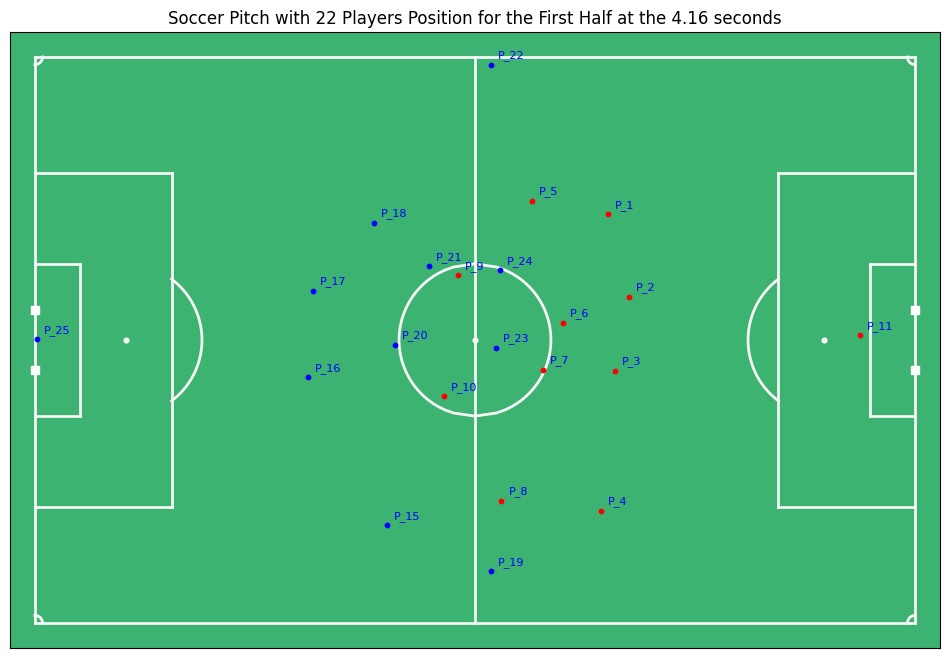

In [19]:
fig, ax = mviz.plot_pitch()

# Prepare player positions and their coordinates on the pitch
home_frame = period_1_data_home.iloc[53]
away_frame = period_1_data_away.iloc[53]
pos_x = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-x" in period_1_data_home.columns[i]]
pos_y = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-y" in period_1_data_home.columns[i]]
pos_x = pos_x + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-x" in period_1_data_away.columns[i]]
pos_y = pos_y + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-y" in period_1_data_away.columns[i]]

data_x, col_x = [item[0] for item in pos_x], [item[1] for item in pos_x]
data_y, col_y = [item[0] for item in pos_y], [item[1] for item in pos_y]

positions_x = pd.DataFrame([data_x], columns=col_x)
positions_y = pd.DataFrame([data_y], columns=col_y)

# Changing the dataset to meter or pitch coordinates
positions_x = mio.to_metric_coordinates(positions_x)
positions_y = mio.to_metric_coordinates(positions_y)

MEAN_X_POS = positions_x.mean(axis=1)[0]
DIRECTION_TO_GOAL = "<--" if MEAN_X_POS > 0 else "-->"
DIRECTION_TO_GOAL += " Direction To Goal"

# Annotate player names
for i, (x, y, name) in enumerate(zip(positions_x.iloc[0], positions_y.iloc[0], player_pos)):
    color = "red"
    if i > 10:
        color = "blue"
    ax.scatter(x, y, color=color, s=10, zorder=2)  # Plot red dot
    ax.annotate(name, (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')
# ax.annotate(DIRECTION_TO_GOAL, (MEAN_X_POS, 29.55), xytext=(MEAN_X_POS, 29.55), textcoords="offset points", fontsize=18, color="red")

seconds = home_frame.iloc[2]
plt.title(f"Soccer Pitch with 22 Players Position for the First Half at the {seconds} seconds")
plt.show()

In [20]:
period_1_data_home

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
51          1     51     2.04    0.64787     0.27031    0.67763     0.42630   
52          1     52     2.08    0.64797     0.27005    0.67765     0.42629   
53          1     53     2.12    0.64805     0.26978    0.67767     0.42637   
54          1     54     2.16    0.64815     0.26943    0.67769     0.42634   
55          1     55      2.2    0.64826     0.26908     0.6777     0.42630   
...       ...    ...      ...        ...         ...        ...         ...   
67853       1  67853  2714.12    0.50464     0.58939    0.52868     0.71467   
67854       1  67854  2714.16    0.50473     0.59095    0.52857     0.71567   
67855       1  67855   2714.2    0.50482     0.59251    0.52846     0.71667   
67856       1  67856  2714.24    0.50492     0.59407    0.52836     0.71766   
67857       1  67857  2714.28    0.50503     0.59563    0.52826     0.71865   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Home-P_8-x Home-P_8-y  \
51       0.68143     0.54622    0.64436  ...     0.53316    0.78648   
52       0.68101     0.54602    0.64428  ...     0.53323    0.78651   
53        0.6806     0.54582    0.64418  ...     0.53328    0.78657   
54        0.6802     0.54562    0.64409  ...     0.53334    0.78658   
55       0.67978     0.54545    0.64398  ...     0.53341    0.78658   
...          ...         ...        ...  ...         ...        ...   
67853    0.55447     0.80078    0.51242  ...     0.38271    0.44293   
67854    0.55441     0.80154    0.51242  ...     0.38291    0.44371   
67855    0.55435     0.80230    0.51242  ...     0.38309    0.44450   
67856    0.55428     0.80303    0.51242  ...      0.3833    0.44529   
67857    0.55419     0.80382    0.51242  ...     0.38349    0.44609   

       Home-P_9-x Home-P_9-y  Home-P_10-x Home-P_10-y  Home-P_11-x  \
51         0.5014    0.35295      0.50046     0.65322      0.94791   
52        0.50128    0.35261      0.50036     0.65297      0.94779   
53        0.50115    0.35226      0.50025     0.65270      0.94766   
54        0.50102    0.35198      0.50011     0.65247      0.94756   
55        0.50088    0.35169      0.49994     0.65213      0.94746   
...           ...        ...          ...         ...          ...   
67853     0.32281    0.54837      0.31453     0.73709      0.90287   
67854     0.32315    0.54893       0.3148     0.73775      0.90178   
67855     0.32349    0.54951      0.31508     0.73845       0.9007   
67856     0.32385    0.55009      0.31537     0.73920      0.89961   
67857     0.32419    0.55061      0.31565     0.73999      0.89852   

      Home-P_11-y   ball-x   ball-y  
51        0.48986  0.50216  0.50376  
52        0.49005   0.5004  0.50384  
53        0.49025   0.4977  0.50397  
54        0.49039    0.495  0.50410  
55        0.49049   0.4923  0.50422  
...           ...      ...      ...  
67853     0.64323  0.00161  0.50354  
67854     0.64435  0.00341  0.49632  
67855     0.64545  0.00522  0.48911  
67856     0.64660  0.00702  0.48190  
67857     0.64773  0.00883  0.47469  

[48527 rows x 27 columns]

In [21]:
period_1_data_away

Period  Frame  Time[s] Away-P_25-x  Away-P_25-y Away-P_15-x  \
51          1     51     2.04     0.00315      0.50293     0.38528   
52          1     52     2.08     0.00315      0.50293     0.38535   
53          1     53     2.12     0.00315      0.50293     0.38542   
54          1     54     2.16     0.00315      0.50293      0.3855   
55          1     55      2.2     0.00314      0.50291     0.38559   
...       ...    ...      ...         ...          ...         ...   
67853       1  67853  2714.12     0.00095      0.50644     0.40104   
67854       1  67854  2714.16     0.00099      0.50669     0.40104   
67855       1  67855   2714.2     0.00106      0.50698     0.40104   
67856       1  67856  2714.24     0.00114      0.50727     0.40104   
67857       1  67857  2714.28     0.00122      0.50756     0.40104   

       Away-P_15-y Away-P_16-x  Away-P_16-y Away-P_17-x  ...  Away-P_21-x  \
51         0.82061      0.3085      0.56600     0.31453  ...      0.43295   
52         0.82071     0.30849      0.56598     0.31434  ...      0.43299   
53         0.82083     0.30846      0.56595     0.31415  ...      0.43305   
54         0.82093     0.30845      0.56595     0.31398  ...      0.43311   
55         0.82100     0.30844      0.56595     0.31381  ...      0.43317   
...            ...         ...          ...         ...  ...          ...   
67853      0.91503     0.31453      0.73709     0.30318  ...      0.42682   
67854      0.91503      0.3148      0.73775     0.30344  ...      0.42686   
67855      0.91503     0.31508      0.73845      0.3037  ...      0.42689   
67856      0.91503     0.31537      0.73920     0.30397  ...      0.42693   
67857      0.91503     0.31565      0.73999     0.30424  ...      0.42696   

      Away-P_21-y  Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  \
51        0.37750      0.49511     0.02246      0.50216     0.50376   
52        0.37743      0.49508     0.02249      0.50214     0.50371   
53        0.37735      0.49507     0.02242      0.50209     0.50366   
54        0.37727      0.49505     0.02235      0.50203     0.50361   
55        0.37719      0.49505     0.02218      0.50195     0.50356   
...           ...          ...         ...          ...         ...   
67853     0.56888      0.36177     0.37021      0.53603     0.86863   
67854     0.56960      0.36142     0.37082      0.53588     0.86944   
67855     0.57027      0.36106     0.37152      0.53572     0.87025   
67856     0.57099      0.36071     0.37223      0.53556     0.87106   
67857     0.57172      0.36036     0.37294      0.53541     0.87190   

       Away-P_24-x Away-P_24-y   ball-x   ball-y  
51         0.49565     0.36179  0.50216  0.50376  
52          0.4958     0.36160   0.5004  0.50384  
53         0.49587     0.36151   0.4977  0.50397  
54         0.49598     0.36131    0.495  0.50410  
55         0.49605     0.36121   0.4923  0.50422  
...            ...         ...      ...      ...  
67853      0.46103     0.54963  0.00161  0.50354  
67854      0.46106     0.55049  0.00341  0.49632  
67855       0.4611     0.55129  0.00522  0.48911  
67856      0.46114     0.55210  0.00702  0.48190  
67857      0.46117     0.55291  0.00883  0.47469  

[48527 rows x 27 columns]

## Tracking for individual Players for the First Period

In [22]:
period_1_data = pd.concat([period_1_data_home.iloc[:, :-2],  period_1_data_away.iloc[:, 3:]], axis=1)

In [23]:
period_1_data

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
51          1     51     2.04    0.64787     0.27031    0.67763     0.42630   
52          1     52     2.08    0.64797     0.27005    0.67765     0.42629   
53          1     53     2.12    0.64805     0.26978    0.67767     0.42637   
54          1     54     2.16    0.64815     0.26943    0.67769     0.42634   
55          1     55      2.2    0.64826     0.26908     0.6777     0.42630   
...       ...    ...      ...        ...         ...        ...         ...   
67853       1  67853  2714.12    0.50464     0.58939    0.52868     0.71467   
67854       1  67854  2714.16    0.50473     0.59095    0.52857     0.71567   
67855       1  67855   2714.2    0.50482     0.59251    0.52846     0.71667   
67856       1  67856  2714.24    0.50492     0.59407    0.52836     0.71766   
67857       1  67857  2714.28    0.50503     0.59563    0.52826     0.71865   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Away-P_21-x Away-P_21-y  \
51       0.68143     0.54622    0.64436  ...      0.43295     0.37750   
52       0.68101     0.54602    0.64428  ...      0.43299     0.37743   
53        0.6806     0.54582    0.64418  ...      0.43305     0.37735   
54        0.6802     0.54562    0.64409  ...      0.43311     0.37727   
55       0.67978     0.54545    0.64398  ...      0.43317     0.37719   
...          ...         ...        ...  ...          ...         ...   
67853    0.55447     0.80078    0.51242  ...      0.42682     0.56888   
67854    0.55441     0.80154    0.51242  ...      0.42686     0.56960   
67855    0.55435     0.80230    0.51242  ...      0.42689     0.57027   
67856    0.55428     0.80303    0.51242  ...      0.42693     0.57099   
67857    0.55419     0.80382    0.51242  ...      0.42696     0.57172   

       Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  Away-P_24-x  \
51         0.49511     0.02246      0.50216     0.50376      0.49565   
52         0.49508     0.02249      0.50214     0.50371       0.4958   
53         0.49507     0.02242      0.50209     0.50366      0.49587   
54         0.49505     0.02235      0.50203     0.50361      0.49598   
55         0.49505     0.02218      0.50195     0.50356      0.49605   
...            ...         ...          ...         ...          ...   
67853      0.36177     0.37021      0.53603     0.86863      0.46103   
67854      0.36142     0.37082      0.53588     0.86944      0.46106   
67855      0.36106     0.37152      0.53572     0.87025       0.4611   
67856      0.36071     0.37223      0.53556     0.87106      0.46114   
67857      0.36036     0.37294      0.53541     0.87190      0.46117   

      Away-P_24-y   ball-x   ball-y  
51        0.36179  0.50216  0.50376  
52        0.36160   0.5004  0.50384  
53        0.36151   0.4977  0.50397  
54        0.36131    0.495  0.50410  
55        0.36121   0.4923  0.50422  
...           ...      ...      ...  
67853     0.54963  0.00161  0.50354  
67854     0.55049  0.00341  0.49632  
67855     0.55129  0.00522  0.48911  
67856     0.55210  0.00702  0.48190  
67857     0.55291  0.00883  0.47469  

[48527 rows x 49 columns]

In [24]:
def player_tracking(dataset: pd.DataFrame, players: list[int] = [11], plot_ball: bool =True, use_annotation: bool = False, sides: list[str] = None, markersize: int = 7):
    fig, ax = mviz.plot_pitch()
    ball_is_not_there = plot_ball
    title = "Player, and Side at each intervals"
    if use_annotation:
        title = "Player, and Frame at each intervals"
    
    for i, (player, side) in enumerate(zip(players, sides)):
        x = f"{side}-P_{player}-x"
        y = f"{side}-P_{player}-y"
    
        # Prepare player positions and their coordinates on the pitch
        data_x = pd.to_numeric(dataset[x], errors='coerce')
        data_y = pd.to_numeric(dataset[y], errors='coerce')
        
        # Create DataFrames with a single column for x and y coordinate of a player
        positions_x = pd.DataFrame(data_x, columns=[x])
        positions_y = pd.DataFrame(data_y, columns=[y])
        
        # Changing the dataset to metric or pitch coordinates
        positions_x = mio.to_metric_coordinates(positions_x)
        positions_y = mio.to_metric_coordinates(positions_y)

        color = color_map[i % len(color_map)]
        
        # Plot player movement with arrows
        for j in range(len(positions_x) - 1):
            dx = positions_x[x].iloc[j+1] - positions_x[x].iloc[j]
            dy = positions_y[y].iloc[j+1] - positions_y[y].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(positions_x[x].iloc[j], positions_y[y].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc=color, ec=color, linestyle="dotted", length_includes_head=True)

        # Plot the player path with dots and lines
        if use_annotation:
            for i in range(len(positions_x)):
                ax.plot(positions_x[x].iloc[i], positions_y[y].iloc[i], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"P{use_annotation[i]} - {positions_x.index[i]}")
                ax.text(positions_x[x].iloc[i], positions_y[y].iloc[i], positions_x.index[i], fontsize=12, ha='right')
        else:
            ax.plot(positions_x[x], positions_y[y], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"Player {player} - {side}")
        ax.plot(positions_x[x].iloc[0], positions_y[y].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=3)
        ax.plot(positions_x[x].iloc[-1], positions_y[y].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=3)
                    
        # ax.annotate("Start Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        # ax.annotate("End Point", (positions_x[x].iloc[-1], positions_y[y].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)

    if ball_is_not_there:
        ba_x = pd.to_numeric(dataset["ball-x"], errors='coerce')
        ba_y = pd.to_numeric(dataset["ball-y"], errors='coerce')
        
        ba_x = mio.to_metric_coordinates(pd.DataFrame(ba_x, columns=["ball-x"]))
        ba_y = mio.to_metric_coordinates(pd.DataFrame(ba_y, columns=["ball-y"]))
        
        ax.plot(ba_x["ball-x"], ba_y["ball-y"], marker=".", linestyle="-.", markersize=int(markersize * 1.5), color="black", zorder=2, label="Ball")
        ax.plot(ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=2)
        ax.plot(ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=2)
        
        # Ball movement arrows
        for j in range(len(ba_x) - 1):
            dx = ba_x["ball-x"].iloc[j+1] - ba_x["ball-x"].iloc[j]
            dy = ba_y["ball-y"].iloc[j+1] - ba_y["ball-y"].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(ba_x["ball-x"].iloc[j], ba_y["ball-y"].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc='black', ec='black', linestyle="dotted", length_includes_head=True)
                
        # ax.annotate("Start Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        # ax.annotate("End Point", (ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        
    ball_is_not_there = False
    
    start_seconds = dataset["Time[s]"].iloc[0]
    end_seconds = dataset["Time[s]"].iloc[-1]
    pl = [i for i in players]
    ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {end_seconds} seconds")
    ax.legend(title=title, loc="upper left", fontsize=8)
        
    plt.tight_layout()
    plt.show()

In [25]:
# player_tracking(period_1_data_home)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Grouping players time interval on 1 second interval

In [26]:
period_1_data

Period  Frame  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
51          1     51     2.04    0.64787     0.27031    0.67763     0.42630   
52          1     52     2.08    0.64797     0.27005    0.67765     0.42629   
53          1     53     2.12    0.64805     0.26978    0.67767     0.42637   
54          1     54     2.16    0.64815     0.26943    0.67769     0.42634   
55          1     55      2.2    0.64826     0.26908     0.6777     0.42630   
...       ...    ...      ...        ...         ...        ...         ...   
67853       1  67853  2714.12    0.50464     0.58939    0.52868     0.71467   
67854       1  67854  2714.16    0.50473     0.59095    0.52857     0.71567   
67855       1  67855   2714.2    0.50482     0.59251    0.52846     0.71667   
67856       1  67856  2714.24    0.50492     0.59407    0.52836     0.71766   
67857       1  67857  2714.28    0.50503     0.59563    0.52826     0.71865   

      Home-P_3-x  Home-P_3-y Home-P_4-x  ...  Away-P_21-x Away-P_21-y  \
51       0.68143     0.54622    0.64436  ...      0.43295     0.37750   
52       0.68101     0.54602    0.64428  ...      0.43299     0.37743   
53        0.6806     0.54582    0.64418  ...      0.43305     0.37735   
54        0.6802     0.54562    0.64409  ...      0.43311     0.37727   
55       0.67978     0.54545    0.64398  ...      0.43317     0.37719   
...          ...         ...        ...  ...          ...         ...   
67853    0.55447     0.80078    0.51242  ...      0.42682     0.56888   
67854    0.55441     0.80154    0.51242  ...      0.42686     0.56960   
67855    0.55435     0.80230    0.51242  ...      0.42689     0.57027   
67856    0.55428     0.80303    0.51242  ...      0.42693     0.57099   
67857    0.55419     0.80382    0.51242  ...      0.42696     0.57172   

       Away-P_22-x Away-P_22-y  Away-P_23-x Away-P_23-y  Away-P_24-x  \
51         0.49511     0.02246      0.50216     0.50376      0.49565   
52         0.49508     0.02249      0.50214     0.50371       0.4958   
53         0.49507     0.02242      0.50209     0.50366      0.49587   
54         0.49505     0.02235      0.50203     0.50361      0.49598   
55         0.49505     0.02218      0.50195     0.50356      0.49605   
...            ...         ...          ...         ...          ...   
67853      0.36177     0.37021      0.53603     0.86863      0.46103   
67854      0.36142     0.37082      0.53588     0.86944      0.46106   
67855      0.36106     0.37152      0.53572     0.87025       0.4611   
67856      0.36071     0.37223      0.53556     0.87106      0.46114   
67857      0.36036     0.37294      0.53541     0.87190      0.46117   

      Away-P_24-y   ball-x   ball-y  
51        0.36179  0.50216  0.50376  
52        0.36160   0.5004  0.50384  
53        0.36151   0.4977  0.50397  
54        0.36131    0.495  0.50410  
55        0.36121   0.4923  0.50422  
...           ...      ...      ...  
67853     0.54963  0.00161  0.50354  
67854     0.55049  0.00341  0.49632  
67855     0.55129  0.00522  0.48911  
67856     0.55210  0.00702  0.48190  
67857     0.55291  0.00883  0.47469  

[48527 rows x 49 columns]

In [27]:
period_1_data = period_1_data.drop(columns=["Frame"])

In [28]:
period_1_data

Period  Time[s] Home-P_1-x  Home-P_1-y Home-P_2-x  Home-P_2-y  \
51          1     2.04    0.64787     0.27031    0.67763     0.42630   
52          1     2.08    0.64797     0.27005    0.67765     0.42629   
53          1     2.12    0.64805     0.26978    0.67767     0.42637   
54          1     2.16    0.64815     0.26943    0.67769     0.42634   
55          1      2.2    0.64826     0.26908     0.6777     0.42630   
...       ...      ...        ...         ...        ...         ...   
67853       1  2714.12    0.50464     0.58939    0.52868     0.71467   
67854       1  2714.16    0.50473     0.59095    0.52857     0.71567   
67855       1   2714.2    0.50482     0.59251    0.52846     0.71667   
67856       1  2714.24    0.50492     0.59407    0.52836     0.71766   
67857       1  2714.28    0.50503     0.59563    0.52826     0.71865   

      Home-P_3-x  Home-P_3-y Home-P_4-x  Home-P_4-y  ... Away-P_21-x  \
51       0.68143     0.54622    0.64436     0.77154  ...     0.43295   
52       0.68101     0.54602    0.64428     0.77197  ...     0.43299   
53        0.6806     0.54582    0.64418     0.77242  ...     0.43305   
54        0.6802     0.54562    0.64409     0.77287  ...     0.43311   
55       0.67978     0.54545    0.64398     0.77334  ...     0.43317   
...          ...         ...        ...         ...  ...         ...   
67853    0.55447     0.80078    0.51242     0.77079  ...     0.42682   
67854    0.55441     0.80154    0.51242     0.77079  ...     0.42686   
67855    0.55435     0.80230    0.51242     0.77079  ...     0.42689   
67856    0.55428     0.80303    0.51242     0.77079  ...     0.42693   
67857    0.55419     0.80382    0.51242     0.77079  ...     0.42696   

       Away-P_21-y Away-P_22-x  Away-P_22-y Away-P_23-x  Away-P_23-y  \
51         0.37750     0.49511      0.02246     0.50216      0.50376   
52         0.37743     0.49508      0.02249     0.50214      0.50371   
53         0.37735     0.49507      0.02242     0.50209      0.50366   
54         0.37727     0.49505      0.02235     0.50203      0.50361   
55         0.37719     0.49505      0.02218     0.50195      0.50356   
...            ...         ...          ...         ...          ...   
67853      0.56888     0.36177      0.37021     0.53603      0.86863   
67854      0.56960     0.36142      0.37082     0.53588      0.86944   
67855      0.57027     0.36106      0.37152     0.53572      0.87025   
67856      0.57099     0.36071      0.37223     0.53556      0.87106   
67857      0.57172     0.36036      0.37294     0.53541      0.87190   

      Away-P_24-x  Away-P_24-y   ball-x   ball-y  
51        0.49565      0.36179  0.50216  0.50376  
52         0.4958      0.36160   0.5004  0.50384  
53        0.49587      0.36151   0.4977  0.50397  
54        0.49598      0.36131    0.495  0.50410  
55        0.49605      0.36121   0.4923  0.50422  
...           ...          ...      ...      ...  
67853     0.46103      0.54963  0.00161  0.50354  
67854     0.46106      0.55049  0.00341  0.49632  
67855      0.4611      0.55129  0.00522  0.48911  
67856     0.46114      0.55210  0.00702  0.48190  
67857     0.46117      0.55291  0.00883  0.47469  

[48527 rows x 48 columns]

In [29]:
# Convert all columns to numeric
temp_data = copy.deepcopy(period_1_data)
for col in temp_data.columns:
    if col != "Period" and col != "Time[s]":
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce')
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
    else:
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce').astype(int)

avg_1_sec = pd.DataFrame()

# Calculate averages for each column
for col in temp_data.columns:
    averages = []
    for i in range(0, len(temp_data), 25):
        group = temp_data[col].iloc[i:i+25]
        avg = group.mean()
        averages.append(avg)
    
    # Add the averages for this column to avg_1_sec
    avg_1_sec[col] = averages   

# avg_1_sec.reset_index(drop=True, inplace=True)
avg_1_sec.index = range(1, len(avg_1_sec) + 1)

In [30]:
avg_1_sec = avg_1_sec.iloc[:200]
avg_1_sec

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
1       1.0     2.04    0.649075    0.267862    0.677262    0.426183   
2       1.0     3.04    0.650808    0.270631    0.675158    0.425478   
3       1.0     4.04    0.651694    0.280151    0.676261    0.421896   
4       1.0     5.04    0.661733    0.267924    0.682300    0.409777   
5       1.0     6.04    0.673676    0.231273    0.684500    0.388219   
..      ...      ...         ...         ...         ...         ...   
196     1.0   223.04    0.334739    0.271733    0.444591    0.505351   
197     1.0   224.04    0.321058    0.296502    0.432537    0.502819   
198     1.0   225.04    0.311415    0.305508    0.421522    0.500919   
199     1.0   226.04    0.305824    0.288282    0.414362    0.496142   
200     1.0   227.04    0.303619    0.257752    0.412427    0.490538   

     Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  Away-P_21-x  \
1      0.676346    0.545278    0.643126    0.777459  ...     0.434040   
2      0.665320    0.549432    0.641822    0.791985  ...     0.439949   
3      0.657516    0.555598    0.646048    0.804760  ...     0.454579   
4      0.656030    0.552604    0.655471    0.799333  ...     0.478016   
5      0.654914    0.540658    0.663447    0.770978  ...     0.498419   
..          ...         ...         ...         ...  ...          ...   
196    0.451235    0.727156    0.300443    0.895548  ...     0.213164   
197    0.442180    0.730992    0.298309    0.898710  ...     0.207682   
198    0.435921    0.727079    0.295860    0.889471  ...     0.220398   
199    0.435088    0.720046    0.299867    0.876339  ...     0.244982   
200    0.439619    0.718140    0.312788    0.872858  ...     0.249531   

     Away-P_21-y  Away-P_22-x  Away-P_22-y  Away-P_23-x  Away-P_23-y  \
1       0.376211     0.495640     0.021007     0.502760     0.504104   
2       0.372589     0.504589     0.017182     0.511515     0.507609   
3       0.368341     0.529735     0.012959     0.534513     0.518531   
4       0.360982     0.564856     0.013846     0.566855     0.524310   
5       0.348076     0.586411     0.016337     0.599375     0.520330   
..           ...          ...          ...          ...          ...   
196     0.758317     0.289821     0.471118     0.430290     0.498454   
197     0.747929     0.279804     0.476504     0.419871     0.498872   
198     0.725214     0.272789     0.477570     0.410293     0.496162   
199     0.703648     0.270135     0.470728     0.401650     0.493456   
200     0.700461     0.270934     0.462788     0.395174     0.496323   

     Away-P_24-x  Away-P_24-y    ball-x    ball-y  
1       0.497760     0.361457  0.470664  0.505236  
2       0.511674     0.367192  0.412815  0.508063  
3       0.539336     0.385298  0.412500  0.510373  
4       0.559714     0.400973  0.422494  0.503116  
5       0.571700     0.381762  0.432715  0.384008  
..           ...          ...       ...       ...  
196     0.364368     0.701650  0.215788  0.959715  
197     0.353223     0.701153  0.215654  0.913686  
198     0.342271     0.697308  0.230496  0.840444  
199     0.335890     0.690032  0.273041  0.740677  
200     0.337121     0.686894  0.309487  0.855741  

[200 rows x 48 columns]

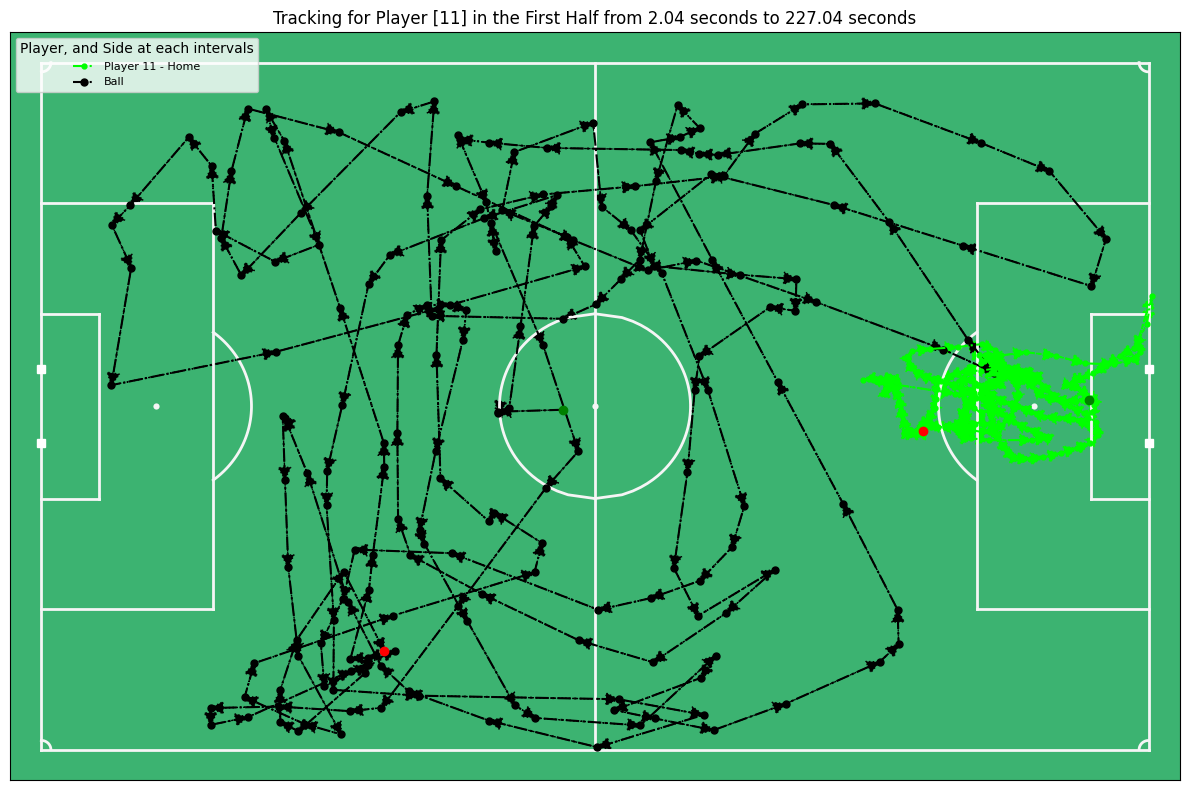

In [31]:
player_tracking(avg_1_sec.loc[:"Home-P_11-y"], plot_ball=True, sides=["Home"]*avg_1_sec.loc[:"Home-P_11-y"].shape[1])

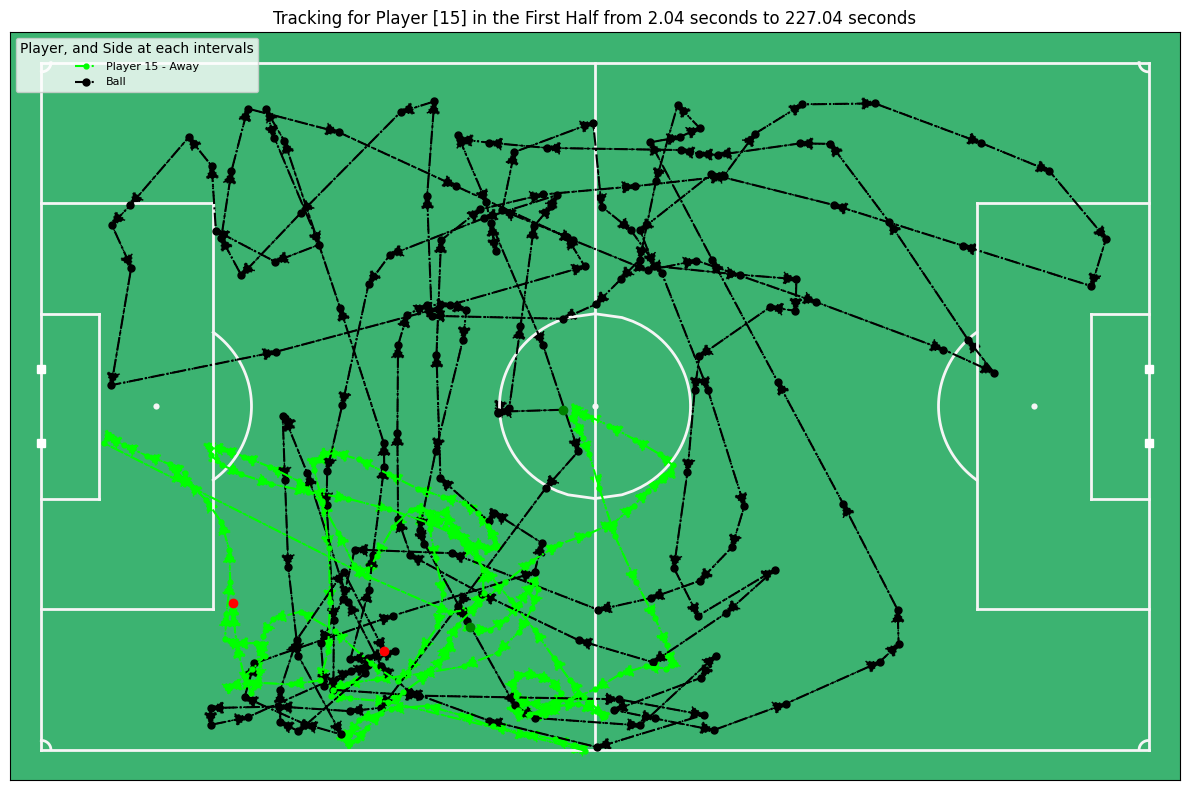

In [32]:
player_tracking(avg_1_sec, [15], sides=["Away"]*1)

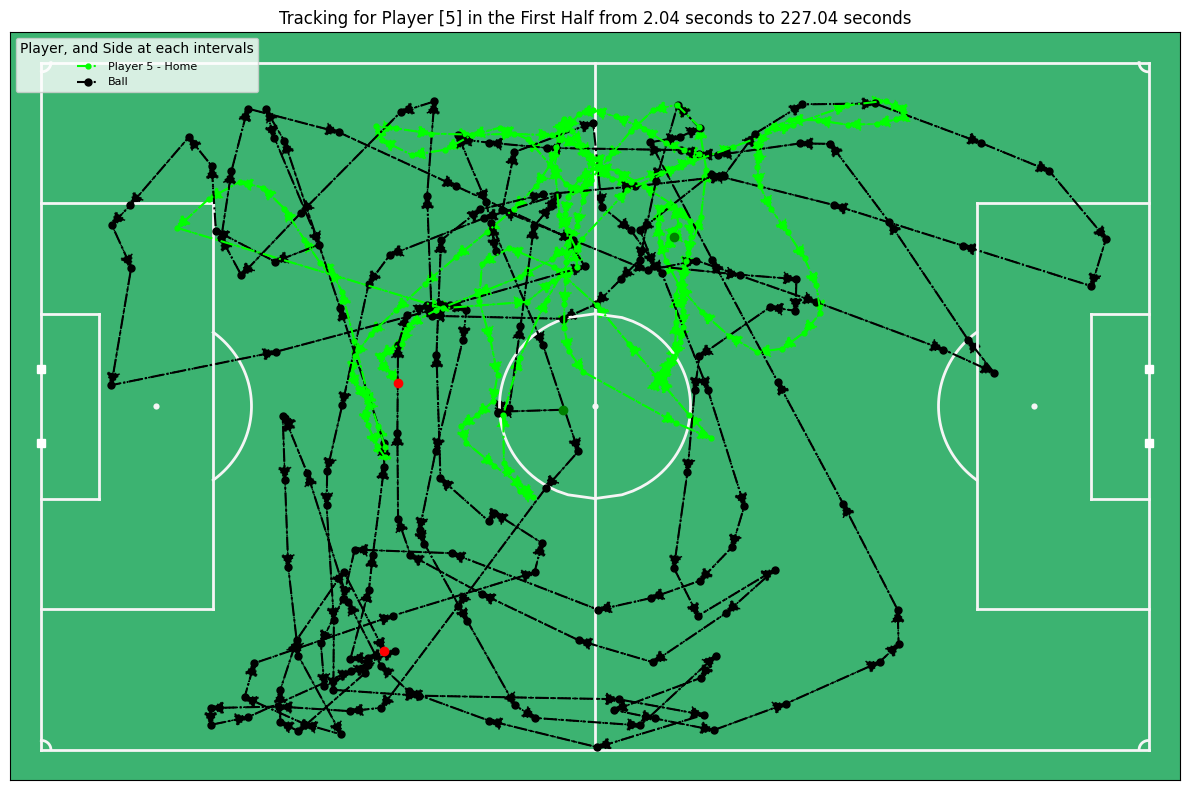

In [33]:
player_tracking(avg_1_sec, [5], sides=["Home"])

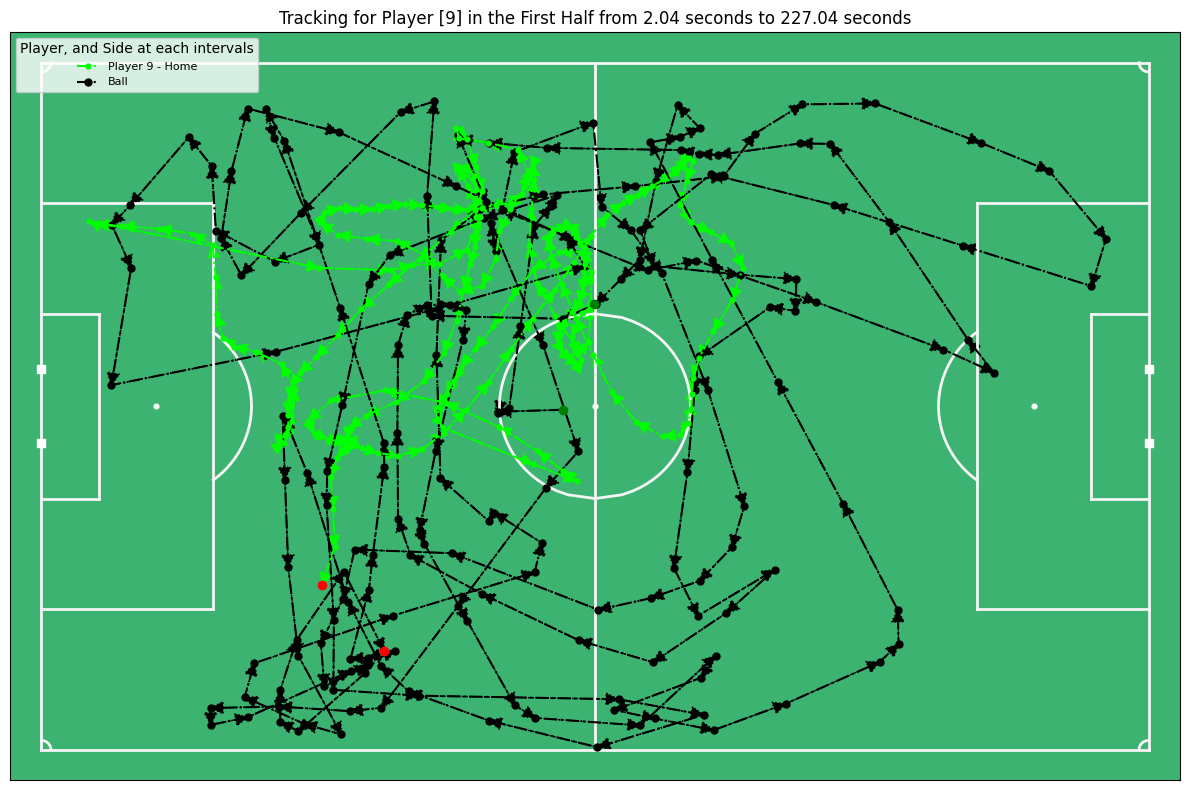

In [34]:
player_tracking(avg_1_sec, [9], sides=["Home"])

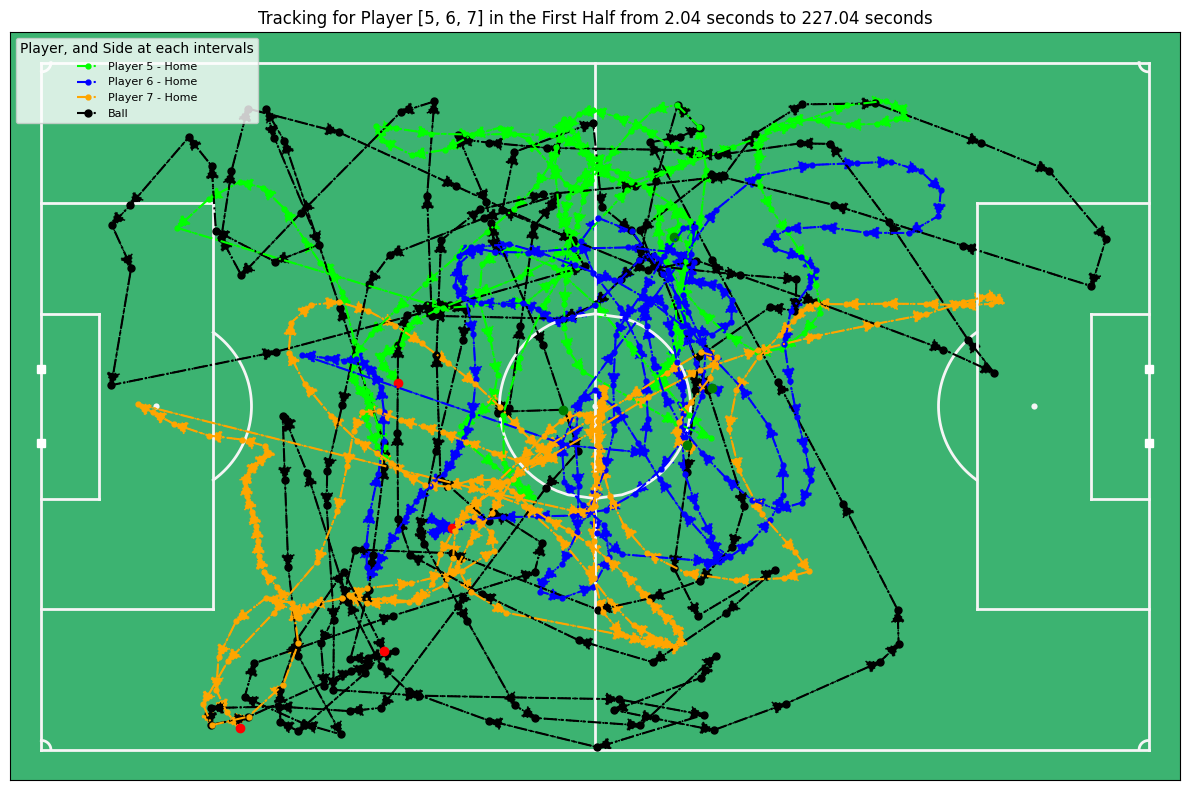

In [35]:
player_tracking(avg_1_sec, [5, 6, 7], sides=["Home"]*3)

In [36]:
# Calculate balls and players speed and direction
def speed_dir(dataset: pd.DataFrame) -> pd.DataFrame:
    temp_data = copy.deepcopy(dataset)
    player_columns = temp_data.columns[2:]

    for i in range(0, player_columns.shape[0] - 1, 2):
        # Calculate Euclidean distance between consecutive points
        ply_x, ply_y = player_columns[i], player_columns[i + 1]
        
        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        distance = np.sqrt(x_diff**2 + y_diff**2)
        
        # Calculate time difference between frames
        time_diff = temp_data['Time[s]'].diff()
        
        # Calculate speed (distance / time)
        # Note: First row will be NaN as we can't calculate speed for a single point
        speed = distance / time_diff
        direction = np.arctan2(x_diff, y_diff)

        if "ball" in ply_x:
            temp_data[f"ball_speed"] = speed
            temp_data[f"ball_direction"] = direction
        else:
            players_num = ply_x[7]
            if len(ply_x) == 11:
                players_num = ply_x[7:9]

            temp_data[f"P_{players_num}_speed"] = speed
            temp_data[f"P_{players_num}_direction"] = direction

    return temp_data

In [37]:
avg_1_sec

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
1       1.0     2.04    0.649075    0.267862    0.677262    0.426183   
2       1.0     3.04    0.650808    0.270631    0.675158    0.425478   
3       1.0     4.04    0.651694    0.280151    0.676261    0.421896   
4       1.0     5.04    0.661733    0.267924    0.682300    0.409777   
5       1.0     6.04    0.673676    0.231273    0.684500    0.388219   
..      ...      ...         ...         ...         ...         ...   
196     1.0   223.04    0.334739    0.271733    0.444591    0.505351   
197     1.0   224.04    0.321058    0.296502    0.432537    0.502819   
198     1.0   225.04    0.311415    0.305508    0.421522    0.500919   
199     1.0   226.04    0.305824    0.288282    0.414362    0.496142   
200     1.0   227.04    0.303619    0.257752    0.412427    0.490538   

     Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  Away-P_21-x  \
1      0.676346    0.545278    0.643126    0.777459  ...     0.434040   
2      0.665320    0.549432    0.641822    0.791985  ...     0.439949   
3      0.657516    0.555598    0.646048    0.804760  ...     0.454579   
4      0.656030    0.552604    0.655471    0.799333  ...     0.478016   
5      0.654914    0.540658    0.663447    0.770978  ...     0.498419   
..          ...         ...         ...         ...  ...          ...   
196    0.451235    0.727156    0.300443    0.895548  ...     0.213164   
197    0.442180    0.730992    0.298309    0.898710  ...     0.207682   
198    0.435921    0.727079    0.295860    0.889471  ...     0.220398   
199    0.435088    0.720046    0.299867    0.876339  ...     0.244982   
200    0.439619    0.718140    0.312788    0.872858  ...     0.249531   

     Away-P_21-y  Away-P_22-x  Away-P_22-y  Away-P_23-x  Away-P_23-y  \
1       0.376211     0.495640     0.021007     0.502760     0.504104   
2       0.372589     0.504589     0.017182     0.511515     0.507609   
3       0.368341     0.529735     0.012959     0.534513     0.518531   
4       0.360982     0.564856     0.013846     0.566855     0.524310   
5       0.348076     0.586411     0.016337     0.599375     0.520330   
..           ...          ...          ...          ...          ...   
196     0.758317     0.289821     0.471118     0.430290     0.498454   
197     0.747929     0.279804     0.476504     0.419871     0.498872   
198     0.725214     0.272789     0.477570     0.410293     0.496162   
199     0.703648     0.270135     0.470728     0.401650     0.493456   
200     0.700461     0.270934     0.462788     0.395174     0.496323   

     Away-P_24-x  Away-P_24-y    ball-x    ball-y  
1       0.497760     0.361457  0.470664  0.505236  
2       0.511674     0.367192  0.412815  0.508063  
3       0.539336     0.385298  0.412500  0.510373  
4       0.559714     0.400973  0.422494  0.503116  
5       0.571700     0.381762  0.432715  0.384008  
..           ...          ...       ...       ...  
196     0.364368     0.701650  0.215788  0.959715  
197     0.353223     0.701153  0.215654  0.913686  
198     0.342271     0.697308  0.230496  0.840444  
199     0.335890     0.690032  0.273041  0.740677  
200     0.337121     0.686894  0.309487  0.855741  

[200 rows x 48 columns]

# Tracking players closest to the ball using frames

In [38]:
period_1_data

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
51          1     2.04     0.64787     0.27031     0.67763     0.42630   
52          1     2.08     0.64797     0.27005     0.67765     0.42629   
53          1     2.12     0.64805     0.26978     0.67767     0.42637   
54          1     2.16     0.64815     0.26943     0.67769     0.42634   
55          1     2.20     0.64826     0.26908     0.67770     0.42630   
...       ...      ...         ...         ...         ...         ...   
67853       1  2714.12     0.50464     0.58939     0.52868     0.71467   
67854       1  2714.16     0.50473     0.59095     0.52857     0.71567   
67855       1  2714.20     0.50482     0.59251     0.52846     0.71667   
67856       1  2714.24     0.50492     0.59407     0.52836     0.71766   
67857       1  2714.28     0.50503     0.59563     0.52826     0.71865   

       Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  Away-P_21-x  \
51        0.68143     0.54622     0.64436     0.77154  ...      0.43295   
52        0.68101     0.54602     0.64428     0.77197  ...      0.43299   
53        0.68060     0.54582     0.64418     0.77242  ...      0.43305   
54        0.68020     0.54562     0.64409     0.77287  ...      0.43311   
55        0.67978     0.54545     0.64398     0.77334  ...      0.43317   
...           ...         ...         ...         ...  ...          ...   
67853     0.55447     0.80078     0.51242     0.77079  ...      0.42682   
67854     0.55441     0.80154     0.51242     0.77079  ...      0.42686   
67855     0.55435     0.80230     0.51242     0.77079  ...      0.42689   
67856     0.55428     0.80303     0.51242     0.77079  ...      0.42693   
67857     0.55419     0.80382     0.51242     0.77079  ...      0.42696   

       Away-P_21-y  Away-P_22-x  Away-P_22-y  Away-P_23-x  Away-P_23-y  \
51         0.37750      0.49511      0.02246      0.50216      0.50376   
52         0.37743      0.49508      0.02249      0.50214      0.50371   
53         0.37735      0.49507      0.02242      0.50209      0.50366   
54         0.37727      0.49505      0.02235      0.50203      0.50361   
55         0.37719      0.49505      0.02218      0.50195      0.50356   
...            ...          ...          ...          ...          ...   
67853      0.56888      0.36177      0.37021      0.53603      0.86863   
67854      0.56960      0.36142      0.37082      0.53588      0.86944   
67855      0.57027      0.36106      0.37152      0.53572      0.87025   
67856      0.57099      0.36071      0.37223      0.53556      0.87106   
67857      0.57172      0.36036      0.37294      0.53541      0.87190   

       Away-P_24-x  Away-P_24-y   ball-x   ball-y  
51         0.49565      0.36179  0.50216  0.50376  
52         0.49580      0.36160  0.50040  0.50384  
53         0.49587      0.36151  0.49770  0.50397  
54         0.49598      0.36131  0.49500  0.50410  
55         0.49605      0.36121  0.49230  0.50422  
...            ...          ...      ...      ...  
67853      0.46103      0.54963  0.00161  0.50354  
67854      0.46106      0.55049  0.00341  0.49632  
67855      0.46110      0.55129  0.00522  0.48911  
67856      0.46114      0.55210  0.00702  0.48190  
67857      0.46117      0.55291  0.00883  0.47469  

[48527 rows x 48 columns]

In [77]:
sp_dir_period_1_data = speed_dir(period_1_data)

In [78]:
sp_dir_period_1_data

Period  Time[s]  Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  \
51          1     2.04     0.64787     0.27031     0.67763     0.42630   
52          1     2.08     0.64797     0.27005     0.67765     0.42629   
53          1     2.12     0.64805     0.26978     0.67767     0.42637   
54          1     2.16     0.64815     0.26943     0.67769     0.42634   
55          1     2.20     0.64826     0.26908     0.67770     0.42630   
...       ...      ...         ...         ...         ...         ...   
67853       1  2714.12     0.50464     0.58939     0.52868     0.71467   
67854       1  2714.16     0.50473     0.59095     0.52857     0.71567   
67855       1  2714.20     0.50482     0.59251     0.52846     0.71667   
67856       1  2714.24     0.50492     0.59407     0.52836     0.71766   
67857       1  2714.28     0.50503     0.59563     0.52826     0.71865   

       Home-P_3-x  Home-P_3-y  Home-P_4-x  Home-P_4-y  ...  P_21_speed  \
51        0.68143     0.54622     0.64436     0.77154  ...         NaN   
52        0.68101     0.54602     0.64428     0.77197  ...    0.002016   
53        0.68060     0.54582     0.64418     0.77242  ...    0.002500   
54        0.68020     0.54562     0.64409     0.77287  ...    0.002500   
55        0.67978     0.54545     0.64398     0.77334  ...    0.002500   
...           ...         ...         ...         ...  ...         ...   
67853     0.55447     0.80078     0.51242     0.77079  ...    0.017794   
67854     0.55441     0.80154     0.51242     0.77079  ...    0.018028   
67855     0.55435     0.80230     0.51242     0.77079  ...    0.016767   
67856     0.55428     0.80303     0.51242     0.77079  ...    0.018028   
67857     0.55419     0.80382     0.51242     0.77079  ...    0.018265   

       P_21_direction  P_22_speed  P_22_direction  P_23_speed  P_23_direction  \
51                NaN         NaN             NaN         NaN             NaN   
52           2.622447    0.001061       -0.785398    0.001346       -2.761086   
53           2.498092    0.001768       -2.999696    0.001768       -2.356194   
54           2.498092    0.001820       -2.863293    0.001953       -2.265535   
55           2.498092    0.004250        3.141593    0.002358       -2.129396   
...               ...         ...             ...         ...             ...   
67853        0.070306    0.020918       -0.431573    0.020594       -0.183111   
67854        0.055499    0.017582       -0.520910    0.020594       -0.183111   
67855        0.044746    0.019679       -0.475011    0.020641       -0.195020   
67856        0.055499    0.019790       -0.457998    0.020641       -0.195020   
67857        0.041073    0.019790       -0.457998    0.021332       -0.176709   

       P_24_speed  P_24_direction  ball_speed  ball_direction  
51            NaN             NaN         NaN             NaN  
52       0.006052        2.473303    0.044045       -1.525373  
53       0.002850        2.480549    0.067578       -1.522685  
54       0.005706        2.638749    0.067578       -1.522685  
55       0.003052        2.530867    0.067567       -1.526381  
...           ...             ...         ...             ...  
67853    0.021274        0.047024    0.064010        2.860611  
67854    0.021513        0.034870    0.186025        2.897266  
67855    0.020025        0.049958    0.185843        2.895635  
67856    0.020275        0.049343    0.185782        2.896940  
67857    0.020264        0.037020    0.185843        2.895635  

[48527 rows x 94 columns]

In [79]:
ply_tra = sp_dir_period_1_data.loc[:67852, "Home-P_1-x":]
ply_tra

Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  Home-P_3-x  Home-P_3-y  \
51        0.64787     0.27031     0.67763     0.42630     0.68143     0.54622   
52        0.64797     0.27005     0.67765     0.42629     0.68101     0.54602   
53        0.64805     0.26978     0.67767     0.42637     0.68060     0.54582   
54        0.64815     0.26943     0.67769     0.42634     0.68020     0.54562   
55        0.64826     0.26908     0.67770     0.42630     0.67978     0.54545   
...           ...         ...         ...         ...         ...         ...   
67848     0.50419     0.58148     0.52921     0.70996     0.55475     0.79688   
67849     0.50428     0.58306     0.52909     0.71088     0.55470     0.79765   
67850     0.50437     0.58463     0.52899     0.71184     0.55464     0.79845   
67851     0.50446     0.58625     0.52889     0.71276     0.55459     0.79922   
67852     0.50455     0.58782     0.52879     0.71367     0.55453     0.80002   

       Home-P_4-x  Home-P_4-y  Home-P_5-x  Home-P_5-y  ...  P_21_speed  \
51        0.64436     0.77154     0.57283     0.25354  ...         NaN   
52        0.64428     0.77197     0.57270     0.25348  ...    0.002016   
53        0.64418     0.77242     0.57257     0.25351  ...    0.002500   
54        0.64409     0.77287     0.57245     0.25345  ...    0.002500   
55        0.64398     0.77334     0.57232     0.25338  ...    0.002500   
...           ...         ...         ...         ...  ...         ...   
67848     0.51242     0.77079     0.43451     0.75697  ...    0.016031   
67849     0.51242     0.77079     0.43471     0.75778  ...    0.016018   
67850     0.51242     0.77079     0.43489     0.75859  ...    0.016298   
67851     0.51242     0.77079     0.43509     0.75943  ...    0.017794   
67852     0.51242     0.77079     0.43528     0.76028  ...    0.019291   

       P_21_direction  P_22_speed  P_22_direction  P_23_speed  P_23_direction  \
51                NaN         NaN             NaN         NaN             NaN   
52           2.622447    0.001061       -0.785398    0.001346       -2.761086   
53           2.498092    0.001768       -2.999696    0.001768       -2.356194   
54           2.498092    0.001820       -2.863293    0.001953       -2.265535   
55           2.498092    0.004250        3.141593    0.002358       -2.129396   
...               ...         ...             ...         ...             ...   
67848        0.062419    0.019680       -0.446604    0.020016       -0.163095   
67849        0.046841    0.020014       -0.452475    0.020349       -0.185348   
67850        0.076772    0.020349       -0.458153    0.020103       -0.187640   
67851        0.070306    0.020465       -0.441793    0.020797       -0.169101   
67852        0.064844    0.020691       -0.436627    0.020887       -0.192701   

       P_24_speed  P_24_direction  ball_speed  ball_direction  
51            NaN             NaN         NaN             NaN  
52       0.006052        2.473303    0.044045       -1.525373  
53       0.002850        2.480549    0.067578       -1.522685  
54       0.005706        2.638749    0.067578       -1.522685  
55       0.003052        2.530867    0.067567       -1.526381  
...           ...             ...         ...             ...  
67848    0.020764        0.036129    0.006005        0.041643  
67849    0.021274        0.047024    0.007267        0.068856  
67850    0.022535        0.055499    0.007289        0.103082  
67851    0.021274        0.047024    0.007267        0.068856  
67852    0.019790        0.063207    0.007319        0.137066  

[48522 rows x 92 columns]

In [80]:
players, ball, sp_dir = ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], ply_tra.loc[:,"ball-x":"ball-y"], ply_tra.loc[:,"P_1_speed":]

In [81]:
players.head()

Home-P_1-x  Home-P_1-y  Home-P_2-x  Home-P_2-y  Home-P_3-x  Home-P_3-y  \
51     0.64787     0.27031     0.67763     0.42630     0.68143     0.54622   
52     0.64797     0.27005     0.67765     0.42629     0.68101     0.54602   
53     0.64805     0.26978     0.67767     0.42637     0.68060     0.54582   
54     0.64815     0.26943     0.67769     0.42634     0.68020     0.54562   
55     0.64826     0.26908     0.67770     0.42630     0.67978     0.54545   

    Home-P_4-x  Home-P_4-y  Home-P_5-x  Home-P_5-y  ...  Away-P_20-x  \
51     0.64436     0.77154     0.57283     0.25354  ...      0.40042   
52     0.64428     0.77197     0.57270     0.25348  ...      0.40045   
53     0.64418     0.77242     0.57257     0.25351  ...      0.40049   
54     0.64409     0.77287     0.57245     0.25345  ...      0.40054   
55     0.64398     0.77334     0.57232     0.25338  ...      0.40059   

    Away-P_20-y  Away-P_21-x  Away-P_21-y  Away-P_22-x  Away-P_22-y  \
51      0.51021      0.43295      0.37750      0.49511      0.02246   
52      0.51021      0.43299      0.37743      0.49508      0.02249   
53      0.51020      0.43305      0.37735      0.49507      0.02242   
54      0.51018      0.43311      0.37727      0.49505      0.02235   
55      0.51010      0.43317      0.37719      0.49505      0.02218   

    Away-P_23-x  Away-P_23-y  Away-P_24-x  Away-P_24-y  
51      0.50216      0.50376      0.49565      0.36179  
52      0.50214      0.50371      0.49580      0.36160  
53      0.50209      0.50366      0.49587      0.36151  
54      0.50203      0.50361      0.49598      0.36131  
55      0.50195      0.50356      0.49605      0.36121  

[5 rows x 44 columns]

In [82]:
ball.head()

ball-x   ball-y
51  0.50216  0.50376
52  0.50040  0.50384
53  0.49770  0.50397
54  0.49500  0.50410
55  0.49230  0.50422

In [83]:
sp_dir.head()

P_1_speed  P_1_direction  P_2_speed  P_2_direction  P_3_speed  \
51        NaN            NaN        NaN            NaN        NaN   
52   0.006964       2.774419   0.000559       2.034444   0.011630   
53   0.007040       2.853537   0.002062       0.244979   0.011404   
54   0.009100       2.863293   0.000901       2.553590   0.011180   
55   0.009172       2.837082   0.001031       2.896614   0.011328   

    P_3_direction  P_4_speed  P_4_direction  P_5_speed  P_5_direction  ...  \
51            NaN        NaN            NaN        NaN            NaN  ...   
52      -2.015216   0.010934      -0.183943   0.003579      -2.003204  ...   
53      -2.024640   0.011524      -0.218669   0.003335      -1.343997  ...   
54      -2.034444   0.011473      -0.197396   0.003354      -2.034444  ...   
55      -1.955401   0.012068      -0.229904   0.003691      -2.064738  ...   

    P_21_speed  P_21_direction  P_22_speed  P_22_direction  P_23_speed  \
51         NaN             NaN         NaN             NaN         NaN   
52    0.002016        2.622447    0.001061       -0.785398    0.001346   
53    0.002500        2.498092    0.001768       -2.999696    0.001768   
54    0.002500        2.498092    0.001820       -2.863293    0.001953   
55    0.002500        2.498092    0.004250        3.141593    0.002358   

    P_23_direction  P_24_speed  P_24_direction  ball_speed  ball_direction  
51             NaN         NaN             NaN         NaN             NaN  
52       -2.761086    0.006052        2.473303    0.044045       -1.525373  
53       -2.356194    0.002850        2.480549    0.067578       -1.522685  
54       -2.265535    0.005706        2.638749    0.067578       -1.522685  
55       -2.129396    0.003052        2.530867    0.067567       -1.526381  

[5 rows x 46 columns]

In [84]:
result = pd.DataFrame(index=ply_tra.index)
result["Time[s]"] = sp_dir_period_1_data["Time[s]"]

for i in range(0, players.shape[1] - 1, 2):
    ply_x, ply_y = players.iloc[:, i], players.iloc[:, i + 1]
    eu_x = np.square(ply_x - ball["ball-x"])
    eu_y = np.square(ply_y - ball["ball-y"])
    distance = np.sqrt(eu_x + eu_y)
    result[f"{players.columns[i][:-2]}"] = distance

In [85]:
result

Time[s]  Home-P_1  Home-P_2  Home-P_3  Home-P_4  Home-P_5  Home-P_6  \
51        2.04  0.275191  0.191807  0.184230  0.303195  0.260008  0.106888   
52        2.08  0.276468  0.193472  0.185470  0.304295  0.260591  0.108682   
53        2.12  0.278299  0.195987  0.187627  0.305813  0.261411  0.111383   
54        2.16  0.280223  0.198550  0.189797  0.307352  0.262343  0.114103   
55        2.20  0.282160  0.201109  0.191960  0.308921  0.263294  0.116815   
...        ...       ...       ...       ...       ...       ...       ...   
67848  2713.92  0.509201  0.566835  0.626226  0.576623  0.501680  0.515509   
67849  2713.96  0.509466  0.566933  0.626388  0.576472  0.502097  0.515684   
67850  2714.00  0.509722  0.567055  0.626547  0.576312  0.502488  0.515871   
67851  2714.04  0.510000  0.567173  0.626710  0.576161  0.502921  0.516053   
67852  2714.08  0.510253  0.567269  0.626860  0.575992  0.503333  0.516214   

       Home-P_7  Home-P_8  Home-P_9  ...  Away-P_15  Away-P_16  Away-P_17  \
51     0.098654  0.284414  0.150812  ...   0.337720   0.203416   0.204798   
52     0.099907  0.284570  0.151233  ...   0.337110   0.201720   0.203449   
53     0.101924  0.284831  0.151749  ...   0.336165   0.199131   0.201267   
54     0.103974  0.285070  0.152239  ...   0.335219   0.196536   0.199054   
55     0.106052  0.285337  0.152771  ...   0.334270   0.193946   0.196844   
...         ...       ...       ...  ...        ...        ...        ...   
67848  0.608014  0.386550  0.322896  ...   0.573111   0.387556   0.305055   
67849  0.608444  0.386628  0.323262  ...   0.572889   0.387909   0.305342   
67850  0.608875  0.386726  0.323601  ...   0.572661   0.388255   0.305640   
67851  0.609306  0.386825  0.323944  ...   0.572439   0.388630   0.305958   
67852  0.609723  0.386913  0.324269  ...   0.572204   0.388987   0.306248   

       Away-P_18  Away-P_19  Away-P_20  Away-P_21  Away-P_22  Away-P_23  \
51      0.238774   0.410884   0.101944   0.143985   0.481352   0.000000   
52      0.238035   0.410777   0.100153   0.143261   0.481379   0.001745   
53      0.236808   0.410660   0.097409   0.142170   0.481557   0.004401   
54      0.235575   0.410510   0.094655   0.141125   0.481750   0.007047   
55      0.234355   0.410418   0.091898   0.140118   0.482048   0.009673   
...          ...        ...        ...        ...        ...        ...   
67848   0.332923   0.587402   0.455211   0.430085   0.388221   0.645527   
67849   0.332990   0.587718   0.455614   0.430144   0.387722   0.645670   
67850   0.333069   0.588026   0.455975   0.430215   0.387201   0.645800   
67851   0.333145   0.588342   0.456359   0.430305   0.386696   0.645964   
67852   0.333207   0.588657   0.456705   0.430384   0.386168   0.646095   

       Away-P_24  
51      0.142119  
52      0.142314  
53      0.142472  
54      0.142793  
55      0.143059  
...          ...  
67848   0.461804  
67849   0.461873  
67850   0.461948  
67851   0.462019  
67852   0.462075  

[48522 rows x 23 columns]

In [86]:
idx = result.min(axis=1).round(4)
closest_to_ball = result.idxmin(axis=1)
print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, closest_to_ball, idx)))

51 - Away-P_23 - 0.0
52 - Away-P_23 - 0.0017
53 - Away-P_23 - 0.0044
54 - Away-P_23 - 0.007
55 - Away-P_23 - 0.0097
56 - Away-P_23 - 0.0123
57 - Away-P_23 - 0.0149
58 - Away-P_23 - 0.0177
59 - Away-P_23 - 0.0205
60 - Away-P_23 - 0.0233
61 - Away-P_23 - 0.0261
62 - Away-P_23 - 0.0289
63 - Away-P_23 - 0.0317
64 - Away-P_23 - 0.0345
65 - Away-P_23 - 0.0374
66 - Away-P_23 - 0.0402
67 - Away-P_23 - 0.0431
68 - Away-P_23 - 0.0459
69 - Away-P_23 - 0.0488
70 - Away-P_20 - 0.0498
71 - Away-P_20 - 0.047
72 - Away-P_20 - 0.0442
73 - Away-P_20 - 0.0413
74 - Away-P_20 - 0.0385
75 - Away-P_20 - 0.0357
76 - Away-P_20 - 0.0329
77 - Away-P_20 - 0.03
78 - Away-P_20 - 0.0272
79 - Away-P_20 - 0.0244
80 - Away-P_20 - 0.0216
81 - Away-P_20 - 0.0187
82 - Away-P_20 - 0.0159
83 - Away-P_20 - 0.0131
84 - Away-P_20 - 0.0102
85 - Away-P_20 - 0.0074
86 - Away-P_20 - 0.0045
87 - Away-P_20 - 0.0017
88 - Away-P_20 - 0.0002
89 - Away-P_20 - 0.0002
90 - Away-P_20 - 0.0002
91 - Away-P_20 - 0.0002
92 - Away-P_20 - 0.0002

In [87]:
min_dist_to_ball = pd.DataFrame(index=ply_tra.index)
min_dist_to_ball["Time[s]"] = sp_dir_period_1_data["Time[s]"]

for i, (index, c) in enumerate(zip(min_dist_to_ball.index, closest_to_ball)):        
    min_dist_to_ball.loc[index, "Home-P_0-x"] = sp_dir_period_1_data.loc[index, f"{c}-x"]
    min_dist_to_ball.loc[index, "Home-P_0-y"] = sp_dir_period_1_data.loc[index, f"{c}-y"]
        
    min_dist_to_ball.loc[index, f"{c}-x"] = sp_dir_period_1_data.loc[index, f"{c}-x"]
    min_dist_to_ball.loc[index, f"{c}-y"] = sp_dir_period_1_data.loc[index, f"{c}-y"]
    
min_dist_to_ball["ball-x"] = period_1_data["ball-x"]
min_dist_to_ball["ball-y"] = period_1_data["ball-y"]

min_dist_to_ball

Time[s]  Home-P_0-x  Home-P_0-y  Away-P_23-x  Away-P_23-y  Away-P_20-x  \
51        2.04     0.50216     0.50376      0.50216      0.50376          NaN   
52        2.08     0.50214     0.50371      0.50214      0.50371          NaN   
53        2.12     0.50209     0.50366      0.50209      0.50366          NaN   
54        2.16     0.50203     0.50361      0.50203      0.50361          NaN   
55        2.20     0.50195     0.50356      0.50195      0.50356          NaN   
...        ...         ...         ...          ...          ...          ...   
67848  2713.92     0.00081     0.50512          NaN          NaN          NaN   
67849  2713.96     0.00083     0.50541          NaN          NaN          NaN   
67850  2714.00     0.00086     0.50570          NaN          NaN          NaN   
67851  2714.04     0.00090     0.50599          NaN          NaN          NaN   
67852  2714.08     0.00093     0.50624          NaN          NaN          NaN   

       Away-P_20-y  Home-P_9-x  Home-P_9-y  Away-P_21-x  ...  Away-P_22-x  \
51             NaN         NaN         NaN          NaN  ...          NaN   
52             NaN         NaN         NaN          NaN  ...          NaN   
53             NaN         NaN         NaN          NaN  ...          NaN   
54             NaN         NaN         NaN          NaN  ...          NaN   
55             NaN         NaN         NaN          NaN  ...          NaN   
...            ...         ...         ...          ...  ...          ...   
67848          NaN         NaN         NaN          NaN  ...          NaN   
67849          NaN         NaN         NaN          NaN  ...          NaN   
67850          NaN         NaN         NaN          NaN  ...          NaN   
67851          NaN         NaN         NaN          NaN  ...          NaN   
67852          NaN         NaN         NaN          NaN  ...          NaN   

       Away-P_22-y  Home-P_11-x  Home-P_11-y  Home-P_2-x  Home-P_2-y  \
51             NaN          NaN          NaN         NaN         NaN   
52             NaN          NaN          NaN         NaN         NaN   
53             NaN          NaN          NaN         NaN         NaN   
54             NaN          NaN          NaN         NaN         NaN   
55             NaN          NaN          NaN         NaN         NaN   
...            ...          ...          ...         ...         ...   
67848          NaN          NaN          NaN         NaN         NaN   
67849          NaN          NaN          NaN         NaN         NaN   
67850          NaN          NaN          NaN         NaN         NaN   
67851          NaN          NaN          NaN         NaN         NaN   
67852          NaN          NaN          NaN         NaN         NaN   

       Away-P_25-x  Away-P_25-y   ball-x   ball-y  
51             NaN          NaN  0.50216  0.50376  
52             NaN          NaN  0.50040  0.50384  
53             NaN          NaN  0.49770  0.50397  
54             NaN          NaN  0.49500  0.50410  
55             NaN          NaN  0.49230  0.50422  
...            ...          ...      ...      ...  
67848      0.00081      0.50512  0.00079  0.50484  
67849      0.00083      0.50541  0.00081  0.50513  
67850      0.00086      0.50570  0.00084  0.50542  
67851      0.00090      0.50599  0.00086  0.50571  
67852      0.00093      0.50624  0.00090  0.50600  

[48522 rows x 49 columns]

In [88]:
delete_idx = sp_dir[sp_dir["ball_speed"] > BALL_POSSESSION_SPEED].index
min_dist_to_ball = min_dist_to_ball.loc[~min_dist_to_ball.index.isin(delete_idx), :]
min_dist_to_ball

Time[s]  Home-P_0-x  Home-P_0-y  Away-P_23-x  Away-P_23-y  Away-P_20-x  \
51        2.04     0.50216     0.50376      0.50216      0.50376          NaN   
52        2.08     0.50214     0.50371      0.50214      0.50371          NaN   
88        3.52     0.40435     0.50838          NaN          NaN      0.40435   
89        3.56     0.40453     0.50842          NaN          NaN      0.40453   
90        3.60     0.40471     0.50846          NaN          NaN      0.40471   
...        ...         ...         ...          ...          ...          ...   
67848  2713.92     0.00081     0.50512          NaN          NaN          NaN   
67849  2713.96     0.00083     0.50541          NaN          NaN          NaN   
67850  2714.00     0.00086     0.50570          NaN          NaN          NaN   
67851  2714.04     0.00090     0.50599          NaN          NaN          NaN   
67852  2714.08     0.00093     0.50624          NaN          NaN          NaN   

       Away-P_20-y  Home-P_9-x  Home-P_9-y  Away-P_21-x  ...  Away-P_22-x  \
51             NaN         NaN         NaN          NaN  ...          NaN   
52             NaN         NaN         NaN          NaN  ...          NaN   
88         0.50838         NaN         NaN          NaN  ...          NaN   
89         0.50842         NaN         NaN          NaN  ...          NaN   
90         0.50846         NaN         NaN          NaN  ...          NaN   
...            ...         ...         ...          ...  ...          ...   
67848          NaN         NaN         NaN          NaN  ...          NaN   
67849          NaN         NaN         NaN          NaN  ...          NaN   
67850          NaN         NaN         NaN          NaN  ...          NaN   
67851          NaN         NaN         NaN          NaN  ...          NaN   
67852          NaN         NaN         NaN          NaN  ...          NaN   

       Away-P_22-y  Home-P_11-x  Home-P_11-y  Home-P_2-x  Home-P_2-y  \
51             NaN          NaN          NaN         NaN         NaN   
52             NaN          NaN          NaN         NaN         NaN   
88             NaN          NaN          NaN         NaN         NaN   
89             NaN          NaN          NaN         NaN         NaN   
90             NaN          NaN          NaN         NaN         NaN   
...            ...          ...          ...         ...         ...   
67848          NaN          NaN          NaN         NaN         NaN   
67849          NaN          NaN          NaN         NaN         NaN   
67850          NaN          NaN          NaN         NaN         NaN   
67851          NaN          NaN          NaN         NaN         NaN   
67852          NaN          NaN          NaN         NaN         NaN   

       Away-P_25-x  Away-P_25-y   ball-x   ball-y  
51             NaN          NaN  0.50216  0.50376  
52             NaN          NaN  0.50040  0.50384  
88             NaN          NaN  0.40419  0.50835  
89             NaN          NaN  0.40435  0.50838  
90             NaN          NaN  0.40453  0.50842  
...            ...          ...      ...      ...  
67848      0.00081      0.50512  0.00079  0.50484  
67849      0.00083      0.50541  0.00081  0.50513  
67850      0.00086      0.50570  0.00084  0.50542  
67851      0.00090      0.50599  0.00086  0.50571  
67852      0.00093      0.50624  0.00090  0.50600  

[19463 rows x 49 columns]

In [89]:
temp = list(min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1))
sides = []
player_col = []
size = len(temp)
for i in range(size):
    end = 8
    if len(temp[i]) == 11:
        end = 9
    player_col.append(temp[i][7:end])
    sides.append(temp[i][:4])

In [90]:
def get_changes(lst: list[str]):
    change_nums = [lst[0]]
    change_indices = [0]
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_nums.append(lst[i])
            change_indices.append(i)
            
    return change_nums, change_indices

def get_items(lst: list[int], lst2: list[str]):
    items = []
    for i in lst:
        items.append(lst2[i])

    return items

In [91]:
dif_player_col, idxs = get_changes(player_col)
dif_sides = get_items(idxs, sides)
dif_min_dist_to_ball = min_dist_to_ball.iloc[idxs, :]

In [92]:
smallest_dataset = dif_min_dist_to_ball.loc[:5000]

In [93]:
assert len(dif_min_dist_to_ball) == len(dif_player_col)

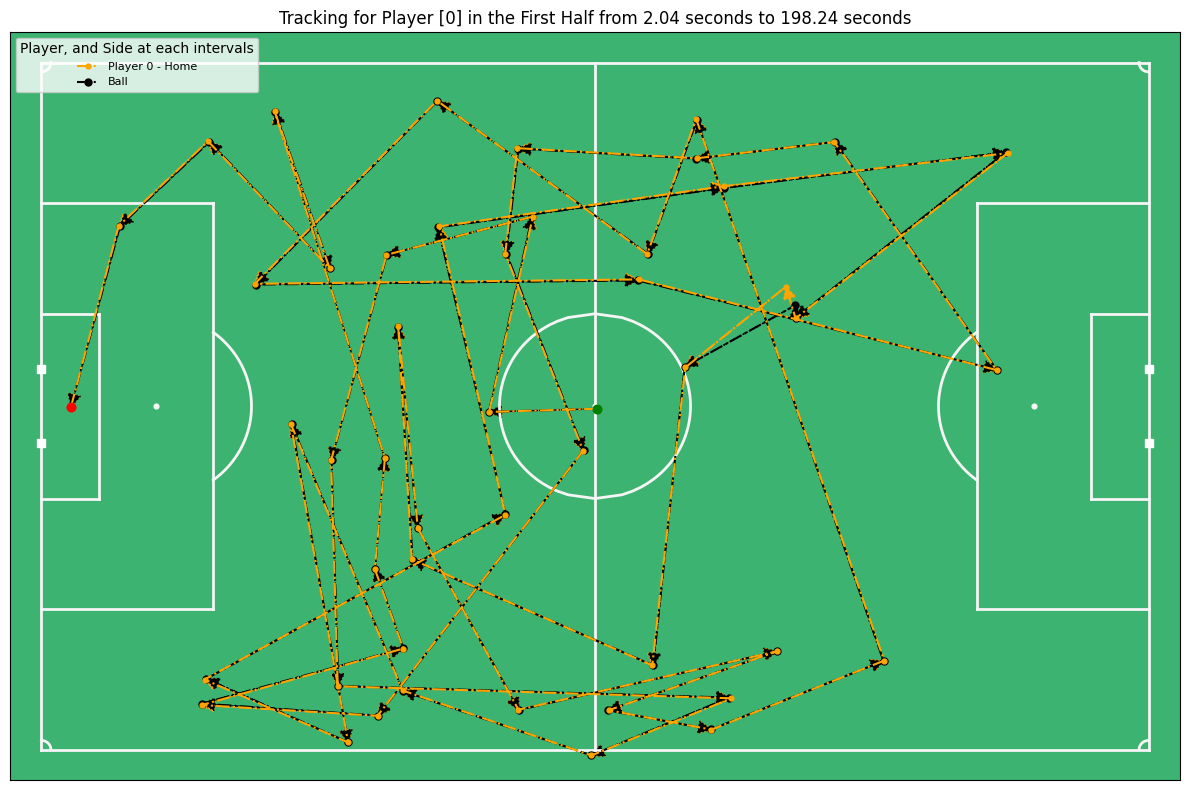

In [94]:
player_tracking(smallest_dataset, plot_ball=True, players=[0], use_annotation=None, sides=["Home"]) # Putting down [0] and ["Home"] because we don't want it to be different color and it's easier

# Classification

In [95]:
dif_min_dist_to_ball

Time[s]  Home-P_0-x  Home-P_0-y  Away-P_23-x  Away-P_23-y  Away-P_20-x  \
51        2.04     0.50216     0.50376      0.50216      0.50376          NaN   
88        3.52     0.40435     0.50838          NaN          NaN      0.40435   
187       7.48     0.44388     0.22400          NaN          NaN          NaN   
284      11.36     0.31168     0.27972          NaN          NaN          NaN   
348      13.92     0.26170     0.57862          NaN          NaN          NaN   
...        ...         ...         ...          ...          ...          ...   
66753  2670.12     0.36516     0.13693          NaN          NaN          NaN   
66773  2670.92     0.37961     0.15984          NaN          NaN          NaN   
66879  2675.16     0.36912     0.42641          NaN          NaN          NaN   
66963  2678.52     0.22268     0.87445          NaN          NaN          NaN   
67119  2684.76     0.03925     0.50351          NaN          NaN          NaN   

       Away-P_20-y  Home-P_9-x  Home-P_9-y  Away-P_21-x  ...  Away-P_22-x  \
51             NaN         NaN         NaN          NaN  ...          NaN   
88         0.50838         NaN         NaN          NaN  ...          NaN   
187            NaN         NaN         NaN          NaN  ...          NaN   
284            NaN         NaN         NaN          NaN  ...          NaN   
348            NaN         NaN         NaN          NaN  ...          NaN   
...            ...         ...         ...          ...  ...          ...   
66753          NaN         NaN         NaN          NaN  ...      0.36516   
66773          NaN         NaN         NaN          NaN  ...          NaN   
66879          NaN         NaN         NaN          NaN  ...          NaN   
66963          NaN         NaN         NaN          NaN  ...          NaN   
67119          NaN         NaN         NaN          NaN  ...          NaN   

       Away-P_22-y  Home-P_11-x  Home-P_11-y  Home-P_2-x  Home-P_2-y  \
51             NaN          NaN          NaN         NaN         NaN   
88             NaN          NaN          NaN         NaN         NaN   
187            NaN          NaN          NaN         NaN         NaN   
284            NaN          NaN          NaN         NaN         NaN   
348            NaN          NaN          NaN         NaN         NaN   
...            ...          ...          ...         ...         ...   
66753      0.13693          NaN          NaN         NaN         NaN   
66773          NaN          NaN          NaN         NaN         NaN   
66879          NaN          NaN          NaN         NaN         NaN   
66963          NaN          NaN          NaN         NaN         NaN   
67119          NaN          NaN          NaN         NaN         NaN   

       Away-P_25-x  Away-P_25-y   ball-x   ball-y  
51             NaN          NaN  0.50216  0.50376  
88             NaN          NaN  0.40419  0.50835  
187            NaN          NaN  0.44312  0.22434  
284            NaN          NaN  0.31207  0.27952  
348            NaN          NaN  0.26207  0.57818  
...            ...          ...      ...      ...  
66753          NaN          NaN  0.36443  0.13622  
66773          NaN          NaN  0.37910  0.16149  
66879          NaN          NaN  0.36858  0.42571  
66963          NaN          NaN  0.22367  0.87323  
67119      0.03925      0.50351  0.03894  0.50484  

[607 rows x 49 columns]

In [96]:
df_event = pd.read_csv("Sample_Game_2_RawEventsData.csv")
df_event_period_1 = df_event[df_event["Period"] == 1]
df_event_period_1

Team       Type          Subtype  Period  Start Frame  Start Time [s]  \
0     Away  SET PIECE         KICK OFF       1           51            2.04   
1     Away       PASS              NaN       1           51            2.04   
2     Away       PASS              NaN       1          146            5.84   
3     Away       PASS              NaN       1          248            9.92   
4     Away       PASS              NaN       1          316           12.64   
...    ...        ...              ...     ...          ...             ...   
1024  Home       PASS              NaN       1        66843         2673.72   
1025  Home       PASS              NaN       1        66929         2677.16   
1026  Home       SHOT   OFF TARGET-OUT       1        67067         2682.68   
1027  Away   RECOVERY              NaN       1        67118         2684.72   
1028  Away  BALL LOST  FORCED-END HALF       1        67852         2714.08   

      End Frame  End Time [s]      From        To  Start X  Start Y  End X  \
0            51          2.04  Player23       NaN      NaN      NaN    NaN   
1            87          3.48  Player23  Player20     0.50     0.50   0.40   
2           186          7.44  Player20  Player18     0.43     0.50   0.44   
3           283         11.32  Player18  Player17     0.47     0.19   0.31   
4           346         13.84  Player17  Player16     0.29     0.32   0.26   
...         ...           ...       ...       ...      ...      ...    ...   
1024      66878       2675.12   Player6   Player5     0.47     0.16   0.37   
1025      66961       2678.44   Player5   Player7     0.34     0.49   0.22   
1026      67107       2684.28   Player7       NaN     0.13     0.77  -0.02   
1027      67118       2684.72  Player25       NaN     0.04     0.50    NaN   
1028      67857       2714.28  Player25       NaN     0.00     0.51   0.01   

      End Y  
0       NaN  
1      0.51  
2      0.22  
3      0.28  
4      0.58  
...     ...  
1024   0.43  
1025   0.87  
1026   0.41  
1027    NaN  
1028   0.47  

[1029 rows x 14 columns]

In [97]:
df_event_period_1_y = df_event_period_1[["Type", "Start Frame", "End Frame"]]
df_event_period_1_y["Current Player"] = change_player_name(df_event_period_1["To"].combine_first(df_event_period_1["From"]))
df_event_period_1_y

C:\Users\noill\AppData\Local\Temp\ipykernel_41060\1484036386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_period_1_y["Current Player"] = change_player_name(df_event_period_1["To"].combine_first(df_event_period_1["From"]))


Type  Start Frame  End Frame Current Player
0     SET PIECE           51         51      Away-P_23
1          PASS           51         87      Away-P_20
2          PASS          146        186      Away-P_18
3          PASS          248        283      Away-P_17
4          PASS          316        346      Away-P_16
...         ...          ...        ...            ...
1024       PASS        66843      66878       Home-P_5
1025       PASS        66929      66961       Home-P_7
1026       SHOT        67067      67107       Home-P_7
1027   RECOVERY        67118      67118      Away-P_25
1028  BALL LOST        67852      67857      Away-P_25

[1029 rows x 4 columns]

In [98]:
start_frames = np.array(df_event_period_1_y["Start Frame"].iloc[1:]) + 2
end_frames = np.array(df_event_period_1_y["End Frame"].iloc[:-1]) - 2

In [99]:
assert start_frames.shape == end_frames.shape
frame_ranges = [np.sort(np.array([i, j])) for i, j in zip(end_frames, start_frames)]

In [100]:
X = [i[:-2] for i in dif_min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1)]
X_idxs = list(dif_min_dist_to_ball.index)
assert len(X_idxs) == len(X)

In [101]:
# def find_idxs_label(event_dataset, ranges, data, data_idxs):
#     assert len(data) == len(data_idxs)
    
#     i = 0
#     j = 0
#     result = []
#     while i < len(ranges) and j < len(data_idxs):
#         item = data_idxs[j]
#         if item > ranges[i][0] and item < ranges[i][1]:
#             if event_dataset.loc[i, "Current Player"] == data[j]:
#                 result.append(i)
#                 j += 1
#         i += 1

#     return result

In [102]:
def find_idxs_label(event_dataset, ranges, data, data_idxs):
    assert len(data) == len(data_idxs)
    
    i = 0  # range index
    j = 0  # data index
    result = []
    
    while i < len(ranges) and j < len(data_idxs):
        item = data_idxs[j]
        
        # Check if the item is within the current range
        if ranges[i][0] < item < ranges[i][1]:
            # Check if "Current Player" matches data[j] within the range
            if event_dataset.loc[i, "Current Player"] == data[j]:
                result.append(i)  # Record the index if there's a match
            
            # Move to the next data index to check for multiple events in the same range
            j += 1
        else:
            # Move to the next range when the current item is outside the current range
            if item >= ranges[i][1]:
                i += 1
            # If item is less than ranges[i][0], we only need to increment `j`
            elif item <= ranges[i][0]:
                j += 1

    return result

In [103]:
idxs_labels = find_idxs_label(df_event_period_1_y, frame_ranges, X, X_idxs) # TODO: need to fix this later because there can be many events in one interval
len(idxs_labels)

448

In [104]:
X = np.array(df_event_period_1_y.iloc[idxs_labels]["Type"])
y = np.array(df_event_period_1_y.iloc[idxs_labels]["Current Player"])
np.unique(X, return_counts=True)

(array(['BALL LOST', 'CHALLENGE', 'PASS', 'RECOVERY', 'SET PIECE'],
       dtype=object),
 array([  2,   7, 417,  14,   8], dtype=int64))

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Why random_state=42

In [106]:
X_test

array(['PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'RECOVERY', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'RECOVERY',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'RECOVERY', 'PASS', 'RECOVERY', 'SET PIECE', 'PASS', 'PASS',
       'PASS', 'PASS', 'RECOVERY', 'PASS', 'PASS', 'SET PIECE', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'SET PIECE', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'CHALLENGE', 'PASS', 'PASS', 'PASS', 'PASS',
       'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS', 'PASS'],
      dtype=object)

In [107]:
# vectorizer = CountVectorizer()
# vectorizer.fit(X_train.ravel())
# X_train = vectorizer.transform(X_train.ravel())
# X_test = vectorizer.transform(X_test.ravel())
# X_train = X_train.toarray()
# X_test = X_test.toarray()

In [108]:
if len(X_train.shape) == 1:
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)

In [109]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), list(range(X_train.shape[1]))),
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [110]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

In [111]:
lg = LogisticRegression(random_state=0)
lg.fit(X_train_resampled, y_train_resampled)
lg_y_pred = lg.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, lg_y_pred)
print("Logistic regression accuracy:", accuracy)

Logistic regression accuracy: 0.08888888888888889


In [112]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train_resampled, y_train_resampled)
rfc_y_pred = rfc.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, rfc_y_pred)
print("Random forest classifier accuracy:", accuracy)

Random forest classifier accuracy: 0.08888888888888889


In [113]:
adc = AdaBoostClassifier(random_state=0)
adc.fit(X_train_resampled, y_train_resampled)
adc_y_pred = adc.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, adc_y_pred)
print("AdaBoost classifier accuracy:", accuracy)

AdaBoost classifier accuracy: 0.05555555555555555
